In [1]:
import pandas as pd
import numpy as np
import dtale
import os
import re

import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_arch
%matplotlib inline

In [2]:
#funções

#Inserir kijos

#Filtra valores numericos com ruidos (Caracteres)
def fillnoisydata(df, lista):
    for i in df.iloc[:,lista].columns:
        df[i] = df[i].apply(lambda x: re.sub(r'(?<=\d)[^\d\.]|^[^\d\.]+|[^\d\.]+$', '', str(x)))
        df[i] = pd.to_numeric(df[i], errors='coerce')
        df[i] = df[i].fillna(0)
    print(df)
    return df


#Analise de valores nulos e não definidos
def analysisnull(df):
    for i in df.columns:
        df1 = df.loc[:, i].isnull().sum()
        df2 = df[i].isin([-1,1]).sum() 
        df3 = (df[i].isin([-1,1]) == False).sum()
        print("{} '\n'Qt Nulo: {}'\n'total Qt -1: {}'\n'total dif -1: {}".format(i, df1, df2,df3))
        
#filtrar valores nulos para data e hora
def fillnull(df, lista):
    df= df.dropna(subset=lista)
    for i in df[lista]:
        df= df[df[i].apply(lambda x : x.isnumeric())]
        df= df[df[i].apply(lambda x: len(x) == 6)]
    return df

#Filtra valores não definidos
def fillnodef(df):
    for i in df.columns:
        j=1
        if(df[i] == 1).all() or (df[i] ==-1).all() or (df[i] == 0).all():
            print("aqui")
            df.drop(i, axis=1, inplace=True)
            j = 0
        if j != 0:
            df[i] = df[i].replace(1, method='ffill')
        else:
            pass
    return df

#Seleciona frota
def selectfleet(df, frota, estado_fill):
    df = df[(df["Frota"] == str(frota)) & (df["Estado Monit"] != estado_fill)]
    return df

#Calculo e plotagem de decomposição aditiva (tendencia, sazonalidade, ciclo e residuo das variaveis do dataset)
def plot_decompose_aditive(df):
    decomp = input("Deseja decomposição aditiva (A) ou multiplicativa (M) ?").upper()
    if decomp == "A":
        decompose = seasonal_decompose(df[i], model='aditive')
    else:
        decompose = seasonal_decompose(df[i], model='multiplicative')
        
    
    for i, j in zip(df.iloc[:,[1,2,3,4]], range(1,len(df.iloc[:,[1,2,3,4]].columns)+1)):
        cycle = df_fill[i] - decompose.seasonal    
        fig, axs = plt.subplots(5, 1, figsize=(12,8))
        axs[0].plot(df[i])
        axs[0].set_title(f'Série temporal original: {i}')
        axs[1].plot(decompose.trend)
        axs[1].set_title('Tendência')
        axs[2].plot(decompose.seasonal)
        axs[2].set_title('Sazonalidade')
        axs[3].plot(cycle)
        axs[3].set_title('Ciclo')
        axs[4].plot(decompose.resid)
        axs[4].set_title('Resíduo')
        fig.tight_layout()
        plt.show()
        print("\n\n\n\n\n")
        
#Calculo e plotagem da media movel e desvio padrão movel das variaveis do dataset
def plot_mean_std_roll(df):
    for i in df.columns[1:5]:
        rolling_mean = df[i].rolling(window = 24).mean() 
        rolling_std = df[i].rolling(window = 24).std()

        plt.figure(figsize=(15,5))
        plt.plot(df[i], color = 'blue', label = 'Original') 
        plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean') 
        plt.plot(rolling_std, color = 'black', label = 'Rolling Std') 
        plt.legend(loc = 'best') 
        plt.title(f'Média Movel & Desvio padrão movel variavel: {i}') 
        plt.show()
        

#Metrica para verificação se a série é estacionaria ou não
def teste_estacionario(df):
    metodo = input("Favor inputar o metodo desejado: ad_fuller (AF) ou KPSS (KP)").upper()
    if metodo == "AF":
        
        for i in df.iloc[:,[1,2,3,4]].columns:
            result = adfuller(df[i])

            # Imprimindo o resultado do 
            print(f"variavel:{i}")
            print('ADF Statistic: %f' % result[0])
            print('p-value: %f' % result[1])
            print('Critical Values:')
            for key, value in result[4].items():
                print('\t%s: %.3f' % (key, value))
            print("\n")
    else:
        for i in df.iloc[:,[1,2,3,4]].columns:
            result = kpss(df[i])
            critical_value = result[3]['5%']  # nível de significância de 5%
            print(f'Variável: {i}')
            print('Estatística do teste KPSS: %.2f' % result[0])
            print(f'Valor-p: {result[1]}')
            print(f'Nível de significância utilizado: {critical_value}')
            if result[1] < critical_value:
                print('Resultado: A série é estacionária.\n')
            else:
                print('Resultado: A série não é estacionária.\n')

def teste_arch(df):

    # Definir a variável de interesse
    for i in df.iloc[:,[1,2,3,4]]:
        y = df[i].values

        # Executar o teste ARCH
        lm, lmpval, fval, fpval = het_arch(y)

        # Analisar os resultados
        if lmpval < 0.05:
            print(f"A variável {i} possui efeitos ARCH significativos.")
            print(f"lmpval {lmpval}")
            print(f"fval {fval}")
            print(f"pval {fpval}")
        else:
            print(f"A variável {i} não possui efeitos ARCH significativos.")
            print(f"lmpval {lmpval}")
            print(f"fval {fval}")
            print(f"pval {fpval}")
                


In [4]:
%%time
local = input("Insira o local do arquivo: \n")
os.chdir(local)
filelist = os.listdir()
telemetry = pd.read_table('PdM_telemetry.csv', sep=',', error_bad_lines=False, engine = "python")
df2 = pd.read_table('PdM_maint.csv', sep=',', error_bad_lines=False, engine = "python")
df3 = pd.read_table('PdM_errors.csv', sep=',', error_bad_lines=False, engine = "python")
df4 = pd.read_table('PdM_failures.csv', sep=',', error_bad_lines=False, engine = "python")
df5 = pd.read_table('PdM_machines.csv', sep=',', error_bad_lines=False, engine = "python")


Insira o local do arquivo: 
C:\Users\Matheus Keitaro\OneDrive - Tecsoil Automação e Sistemas S.A\Área de Trabalho\TCC Data science e analytics\Formula 1


<timed exec>:4: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.





FileNotFoundError: [Errno 2] No such file or directory: 'PdM_telemetry.csv'

In [4]:
telemetry

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In [5]:
df2

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4
...,...,...,...
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2


In [6]:
df3

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


In [7]:
df4

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


In [8]:
df5

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
...,...,...,...
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14


In [9]:
print('Telemetria:\n', telemetry['machineID'].value_counts(ascending = True),
      '\n\n','Manutenção:\n', df2['machineID'].value_counts(ascending = False),
      '\n\n','Erros:\n' , df3['machineID'].value_counts(ascending = False),
      '\n\n','Falha:\n' , df4['machineID'].value_counts(ascending = False))

Telemetria:
 1      8761
73     8761
72     8761
71     8761
70     8761
       ... 
29     8761
28     8761
27     8761
37     8761
100    8761
Name: machineID, Length: 100, dtype: int64 

 Manutenção:
 70    39
68    39
66    39
42    38
84    38
      ..
89    27
91    27
47    27
74    26
53    25
Name: machineID, Length: 100, dtype: int64 

 Erros:
 22    60
78    54
99    54
49    51
81    51
      ..
19    28
86    27
31    26
6     23
77    22
Name: machineID, Length: 100, dtype: int64 

 Falha:
 99     19
98     16
22     15
17     15
83     14
       ..
100     3
46      2
29      2
72      2
57      2
Name: machineID, Length: 98, dtype: int64


# Analisando o Dataset Telemetria

In [10]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [11]:
telemetry.shape

(876100, 6)

In [12]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [13]:
#Quantidade de dias de dados coletados
telemetry.index = pd.to_datetime(telemetry.index)
print(telemetry.index.unique(), "\nQuantidade de dias:", np.around((telemetry.index.nunique()/24),2))

DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004',
               '1970-01-01 00:00:00.000000005',
               '1970-01-01 00:00:00.000000006',
               '1970-01-01 00:00:00.000000007',
               '1970-01-01 00:00:00.000000008',
               '1970-01-01 00:00:00.000000009',
               ...
               '1970-01-01 00:00:00.000876090',
               '1970-01-01 00:00:00.000876091',
               '1970-01-01 00:00:00.000876092',
               '1970-01-01 00:00:00.000876093',
               '1970-01-01 00:00:00.000876094',
               '1970-01-01 00:00:00.000876095',
               '1970-01-01 00:00:00.000876096',
               '1970-01-01 00:00:00.000876097',
               '1970-01-01 00:00:00.000876098',
               '1970-01-01 00:00:00.000876099'],
              dtype=

In [14]:
#Verificando se o dataset possui valores nulos
telemetry.isna().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64

In [15]:
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"], format="%Y-%m-%d %H:%M:%S")

# DUMMIEZAÇÃO DAS VARIAVEIS QUALITATIVAS

In [16]:
dummies = pd.get_dummies(df2['comp'], "Manutenção")
manutenção = pd.concat([df2.iloc[:,0:2], dummies], axis =1)
manutenção.iloc[:,[2,3,4,5]] = manutenção.iloc[:,[2,3,4,5]].astype(bool)
manutenção["datetime"] = pd.to_datetime(manutenção["datetime"], format="%Y-%m-%d %H:%M:%S")
manutenção

,datetime,machineID,Manutenção_comp1,Manutenção_comp2,Manutenção_comp3,Manutenção_comp4
0,2014-06-01 06:00:00,1,False,True,False,False
1,2014-07-16 06:00:00,1,False,False,False,True
2,2014-07-31 06:00:00,1,False,False,True,False
3,2014-12-13 06:00:00,1,True,False,False,False
4,2015-01-05 06:00:00,1,False,False,False,True
...,...,...,...,...,...,...
3281,2015-10-10 06:00:00,100,False,False,True,False
3282,2015-10-25 06:00:00,100,False,False,False,True
3283,2015-11-09 06:00:00,100,False,False,False,True
3284,2015-12-09 06:00:00,100,False,True,False,False


In [17]:
dummies2 = pd.get_dummies(df3['errorID'], "Erro")
erro = pd.concat([df3.iloc[:,0:2], dummies2], axis =1)
erro.iloc[:,[2,3,4,5,6]] = erro.iloc[:,[2,3,4,5,6]].astype(bool)
erro["datetime"] = pd.to_datetime(erro["datetime"], format="%Y-%m-%d %H:%M:%S")
erro

,datetime,machineID,Erro_error1,Erro_error2,Erro_error3,Erro_error4,Erro_error5
0,2015-01-03 07:00:00,1,True,False,False,False,False
1,2015-01-03 20:00:00,1,False,False,True,False,False
2,2015-01-04 06:00:00,1,False,False,False,False,True
3,2015-01-10 15:00:00,1,False,False,False,True,False
4,2015-01-22 10:00:00,1,False,False,False,True,False
...,...,...,...,...,...,...,...
3914,2015-11-21 08:00:00,100,False,True,False,False,False
3915,2015-12-04 02:00:00,100,True,False,False,False,False
3916,2015-12-08 06:00:00,100,False,True,False,False,False
3917,2015-12-08 06:00:00,100,False,False,True,False,False


In [18]:
dummies3 = pd.get_dummies(df4['failure'], "Falha")
falha = pd.concat([df4.iloc[:,0:2], dummies3], axis =1)
falha.iloc[:,[2,3,4,5]] = falha.iloc[:,[2,3,4,5]].astype(bool)
falha["datetime"] = pd.to_datetime(falha["datetime"], format="%Y-%m-%d %H:%M:%S")
falha

,datetime,machineID,Falha_comp1,Falha_comp2,Falha_comp3,Falha_comp4
0,2015-01-05 06:00:00,1,False,False,False,True
1,2015-03-06 06:00:00,1,True,False,False,False
2,2015-04-20 06:00:00,1,False,True,False,False
3,2015-06-19 06:00:00,1,False,False,False,True
4,2015-09-02 06:00:00,1,False,False,False,True
...,...,...,...,...,...,...
756,2015-11-29 06:00:00,99,False,False,True,False
757,2015-12-14 06:00:00,99,False,False,False,True
758,2015-02-12 06:00:00,100,True,False,False,False
759,2015-09-10 06:00:00,100,True,False,False,False


In [19]:
dummies4 = pd.get_dummies(df5["model"])
modelo = pd.concat([df5.iloc[:,0:3], dummies4], axis =1)
modelo.iloc[:,[3,4,5,6]] = modelo.iloc[:,[3,4,5,6]].astype(bool)
modelo

,machineID,model,age,model1,model2,model3,model4
0,1,model3,18,False,False,True,False
1,2,model4,7,False,False,False,True
2,3,model3,8,False,False,True,False
3,4,model3,7,False,False,True,False
4,5,model3,2,False,False,True,False
...,...,...,...,...,...,...,...
95,96,model2,10,False,True,False,False
96,97,model2,14,False,True,False,False
97,98,model2,20,False,True,False,False
98,99,model1,14,True,False,False,False


In [20]:
#Merge de todos os datasets
dfmerge = pd.merge(telemetry,modelo, how='left', on=['machineID'])
dfmerge = pd.merge(dfmerge,erro, how='left', on=['datetime','machineID'])
dfmerge = pd.merge(dfmerge,manutenção, how='left', on=['datetime','machineID'])
dfmerge = pd.merge(dfmerge,falha, how='left', on=['datetime','machineID'])

#dfmerge["datetime"] = pd.to_datetime(dfmerge["datetime"], format="%Y-%m-%d %H:%M:%S")
dfmerge

,datetime,machineID,volt,rotate,pressure,vibration,model,age,model1,model2,...,Erro_error4,Erro_error5,Manutenção_comp1,Manutenção_comp2,Manutenção_comp3,Manutenção_comp4,Falha_comp1,Falha_comp2,Falha_comp3,Falha_comp4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877204,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,model4,5,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877205,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,model4,5,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877206,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,model4,5,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877207,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,model4,5,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877209 entries, 0 to 877208
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          877209 non-null  datetime64[ns]
 1   machineID         877209 non-null  int64         
 2   volt              877209 non-null  float64       
 3   rotate            877209 non-null  float64       
 4   pressure          877209 non-null  float64       
 5   vibration         877209 non-null  float64       
 6   model             877209 non-null  object        
 7   age               877209 non-null  int64         
 8   model1            877209 non-null  bool          
 9   model2            877209 non-null  bool          
 10  model3            877209 non-null  bool          
 11  model4            877209 non-null  bool          
 12  Erro_error1       3924 non-null    object        
 13  Erro_error2       3924 non-null    object        
 14  Erro

In [22]:
dfmerge["Manutenção_comp1"].value_counts()

False    2245
True      723
Name: Manutenção_comp1, dtype: int64

,datetime,machineID,volt,rotate,pressure,vibration,model,age,model1,model2,...,Erro_error4,Erro_error5,Manutenção_comp1,Manutenção_comp2,Manutenção_comp3,Manutenção_comp4,Falha_comp1,Falha_comp2,Falha_comp3,Falha_comp4
850889,2015-01-01 06:00:00,98,153.300953,453.352244,86.073228,47.791685,model2,20,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850890,2015-01-01 07:00:00,98,171.471504,467.738791,108.083597,48.874200,model2,20,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850891,2015-01-01 08:00:00,98,170.773931,423.939397,102.436656,36.050420,model2,20,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850892,2015-01-01 09:00:00,98,165.851737,491.922937,97.319156,31.528837,model2,20,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850893,2015-01-01 10:00:00,98,175.140637,413.644663,105.284345,35.825416,model2,20,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859665,2016-01-01 02:00:00,98,164.321319,447.495715,105.127837,52.249512,model2,20,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859666,2016-01-01 03:00:00,98,180.410465,485.467071,117.467661,37.321110,model2,20,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859667,2016-01-01 04:00:00,98,158.354201,389.828191,121.270784,38.201489,model2,20,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859668,2016-01-01 05:00:00,98,193.754368,450.198921,127.851932,39.800055,model2,20,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
for i in dfmerge.iloc[:,[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]].columns:
    if dfmerge[i].isna().sum() > 0:
        dfmerge[i] = dfmerge[i].fillna(False)


In [25]:
dfmerge.iloc[:,[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]].columns

Index(['model', 'age', 'model1', 'model2', 'model3', 'model4', 'Erro_error1',
       'Erro_error2', 'Erro_error3', 'Erro_error4', 'Erro_error5',
       'Manutenção_comp1', 'Manutenção_comp2', 'Manutenção_comp3',
       'Manutenção_comp4', 'Falha_comp1', 'Falha_comp2', 'Falha_comp3',
       'Falha_comp4'],
      dtype='object')

In [26]:
dfmerge["Manutenção"] = np.where(dfmerge["Manutenção_comp1"] == True, True, np.where(dfmerge["Manutenção_comp2"] == True, True, np.where(dfmerge["Manutenção_comp3"] == True, True, np.where(dfmerge["Manutenção_comp4"] == True,True,False))))
dfmerge["Erro"] = np.where(dfmerge["Erro_error1"] == True, True, np.where(dfmerge["Erro_error2"] == True, True, np.where(dfmerge["Erro_error3"] == True, True, np.where(dfmerge["Erro_error4"] == True,True,np.where(dfmerge["Erro_error5"] == True, True, False)))))
dfmerge["Falha"] = np.where(dfmerge["Falha_comp1"] == True, True, np.where(dfmerge["Falha_comp2"] == True, True, np.where(dfmerge["Falha_comp3"] == True, True, np.where(dfmerge["Falha_comp4"] == True,True,False))))
#dfmerge["Manutenção/Erro"] = np.where((dfmerge["Manutenção"] == True) & (dfmerge["Erro"] == True), True, False)
#dfmerge["Manutenção/Falha"] = np.where((dfmerge["Manutenção"] == True) & (dfmerge["Falha"] == True), True, False)
#dfmerge["Erro/Falha"] = np.where((dfmerge["Erro"] == True) & (dfmerge["Falha"] == True), True, False)
#dfmerge["Manutenção/Erro/Falha"] = np.where((dfmerge["Manutenção"] == True) & (dfmerge["Erro"] == True) & (dfmerge["Falha"] == True), True, False)

In [27]:
dfmerge.describe().columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'age'], dtype='object')

In [28]:
dfmerge.iloc[:,[2,3,4,5,7]].columns

Index(['volt', 'rotate', 'pressure', 'vibration', 'age'], dtype='object')

findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


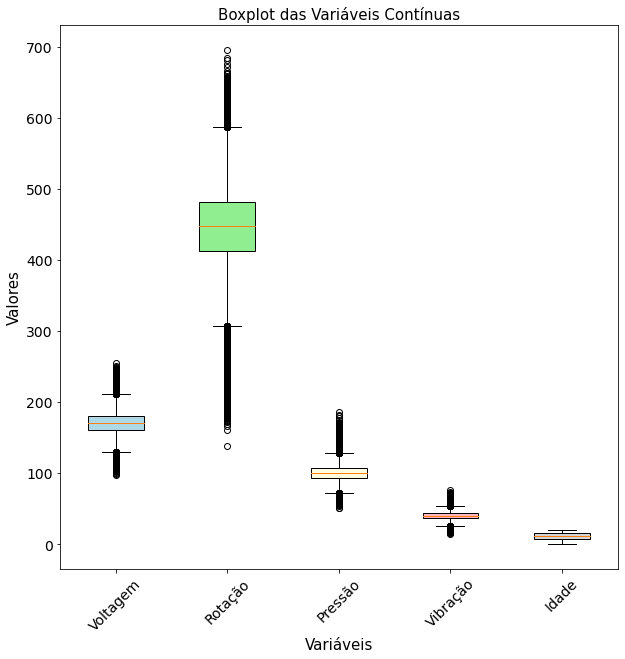

In [29]:
import matplotlib.pyplot as plt

# Selecionando as colunas contendo os dados
column_indices = [2, 3, 4, 5, 7]  # Índices das colunas que você deseja incluir no boxplot
selected_columns = dfmerge.iloc[:, column_indices]  # Seleciona as colunas com os dados

# Criando o boxplot
plt.figure(figsize=(10, 10))  # Ajuste o tamanho da figura conforme necessário
boxplot = plt.boxplot(selected_columns.values, vert=True, patch_artist=True)  # Utilize vert=True para plotar os boxplots na vertical e patch_artist=True para preencher as caixas com cor

# Cores para as caixas dos boxplots
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightgray']

# Personalizando o boxplot
plt.title("Boxplot das Variáveis Contínuas", fontdict = {"fontsize":15})  # Título do gráfico
plt.xlabel("Variáveis", fontdict = {"fontsize":15})  # Rótulo do eixo x
plt.ylabel("Valores", fontdict = {"fontsize":15})  # Rótulo do eixo y
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para facilitar a leitura

# Adicionando cor às caixas dos boxplots
for box, color in zip(boxplot['boxes'], colors):
    box.set(facecolor=color)

# Nome das variáveis no eixo x
nomes_variaveis = dfmerge.columns[column_indices]  # Obtém os nomes das variáveis selecionadas
plt.xticks(range(1, len(nomes_variaveis) + 1), ["Voltagem", "Rotação", "Pressão", "Vibração", "Idade"], fontsize = 14)  # Define os rótulos das variáveis no eixo x
plt.yticks(fontsize = 14)
# Exibindo o boxplot
plt.show()

In [30]:
dfmerge["date"] = dfmerge["datetime"].dt.date

# Selecionando 3 maquinas diferentes para verificar se há diferença significativa nos comportamentos

In [31]:
dfmerge.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,model1,model2,...,Manutenção_comp3,Manutenção_comp4,Falha_comp1,Falha_comp2,Falha_comp3,Falha_comp4,Manutenção,Erro,Falha,date
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01


# Analisando o dataset de Erros

In [32]:
s = dtale.show(dfmerge)
s.open_browser()

In [33]:
df3

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


Text(0, 0.5, 'Tipos de erros')

2023-10-14 16:26:10,592 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
2023-10-14 16:26:10,622 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
2023-10-14 16:26:10,662 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


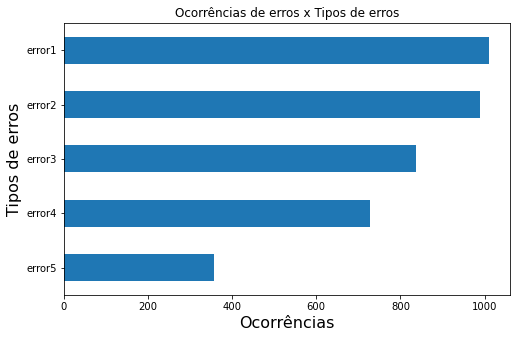

In [34]:
ax = df3["errorID"].value_counts().sort_index(ascending = False).plot(kind = "barh", figsize=(8,5), title = "Ocorrências de erros x Tipos de erros")
ax.set_xlabel("Ocorrências", fontsize=16)
ax.set_ylabel("Tipos de erros", fontsize=16)

In [35]:
erros_group = df3.groupby(["machineID", "errorID"]).size().reset_index()
erros_group.columns = ["machineID", "Erros", "Contagem"]
erros_pivot = pd.pivot(erros_group, index = "machineID", columns = "Erros", values = "Contagem")
erros_pivot

Erros,error1,error2,error3,error4,error5
machineID,,,,,
1,11.0,6.0,9.0,5.0,4.0
2,5.0,10.0,5.0,5.0,3.0
3,11.0,10.0,8.0,8.0,2.0
4,10.0,11.0,8.0,2.0,NaN
5,14.0,8.0,7.0,6.0,3.0
...,...,...,...,...,...
96,5.0,10.0,8.0,12.0,4.0
97,12.0,8.0,5.0,15.0,5.0
98,9.0,12.0,8.0,11.0,5.0


2023-10-14 16:26:11,805 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
2023-10-14 16:26:12,099 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
2023-10-14 16:26:12,410 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


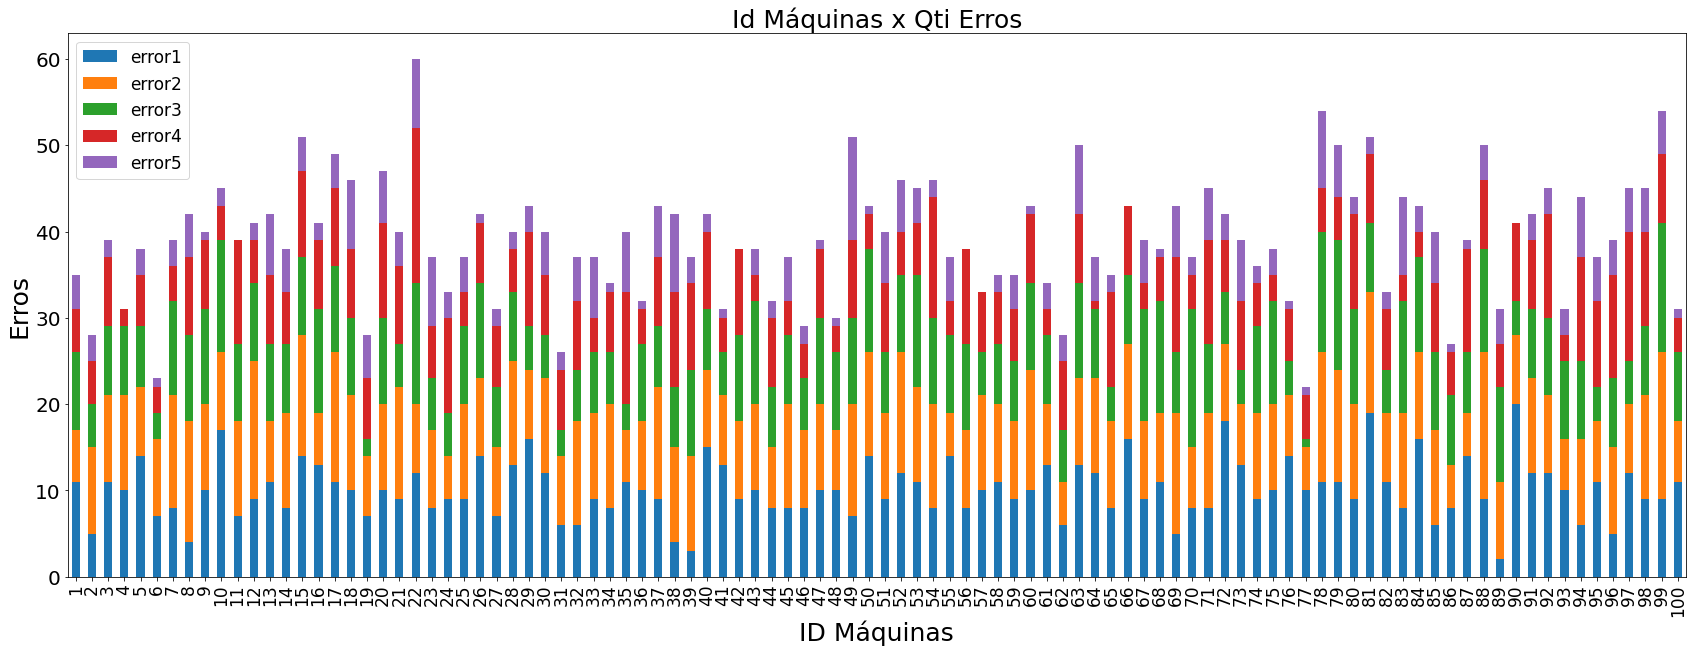

In [36]:
ax = erros_pivot.plot(stacked = True, kind = 'bar', figsize=(29,10), fontsize = 14)
ax.set_xlabel("ID Máquinas", fontsize=25)
ax.set_ylabel("Erros", fontsize=25)
ax.set_title("Id Máquinas x Qti Erros", fontsize = 25)
plt.legend(fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 20)

plt.show()


In [37]:
erros_tempo = dfmerge.groupby(["date","machineID", "Erro"]).size().reset_index()
erros_tempo.columns = ["Data","machineID" ,"Erro", "Contagem"]
erros_tempo_pivot = pd.pivot(erros_tempo, index = "Data", columns = ["machineID","Erro"], values = "Contagem")


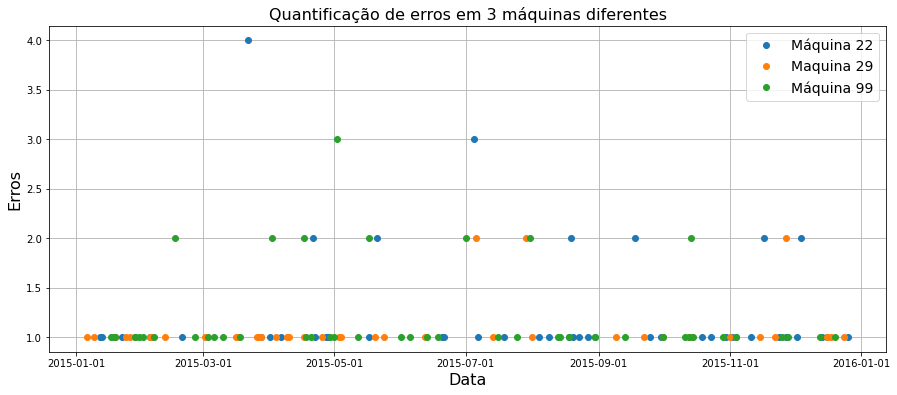

In [38]:
ax = erros_tempo_pivot[[(22,True),(29,True), (99,True)]].plot(figsize=(15, 6),  marker = "o", linestyle = "None", grid = True)
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Erros", fontsize=16)
ax.set_title("Quantificação de erros em 3 máquinas diferentes", fontsize = 16)
plt.legend(fontsize=14)

# Aumentar a quantidade de labels no eixo x
ax.set_xticks(ax.get_xticks()[::1])  # Ajuste o intervalo entre os labels conforme necessário

# Rotacionar os labels do eixo x
#plt.xticks(rotation='vertical')
plt.legend(fontsize=14)
ax.legend(["Máquina 22", "Maquina 29", "Máquina 99"], fontsize=14)

plt.show()

In [39]:
erros_tempo_pivot[[(22,True),(77,True), (99,True)]]

machineID,22,77,99
Erro,True,True,True
Data,,,
2015-01-01,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN
2015-01-03,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN
...,...,...,...
2015-12-28,NaN,NaN,NaN
2015-12-29,NaN,NaN,NaN


# Analisando o dataset de falhas nas máquinas

In [40]:
df4

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

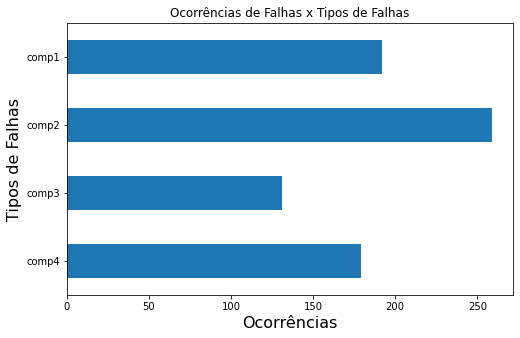

In [41]:
ax = df4["failure"].value_counts().sort_index(ascending=False).plot(kind = "barh", figsize = (8,5))
ax.set_xlabel("Ocorrências", fontsize=16)
ax.set_ylabel("Tipos de Falhas", fontsize=16)
ax.set_title("Ocorrências de Falhas x Tipos de Falhas")
#plt.legend(fontsize=14)
df4["failure"].value_counts()

In [42]:
falhas_group = df4.groupby(["machineID", "failure"]).size().reset_index()
falhas_group.columns = ["machineID", "Falhas", "Contagem"]
x'
falhas_pivot

Falhas,comp1,comp2,comp3,comp4
machineID,,,,
1,1.0,2.0,NaN,4.0
2,1.0,3.0,NaN,NaN
3,1.0,4.0,NaN,NaN
4,2.0,4.0,NaN,NaN
5,4.0,3.0,NaN,NaN
...,...,...,...,...
96,NaN,NaN,5.0,NaN
97,NaN,1.0,3.0,4.0
98,4.0,4.0,5.0,3.0


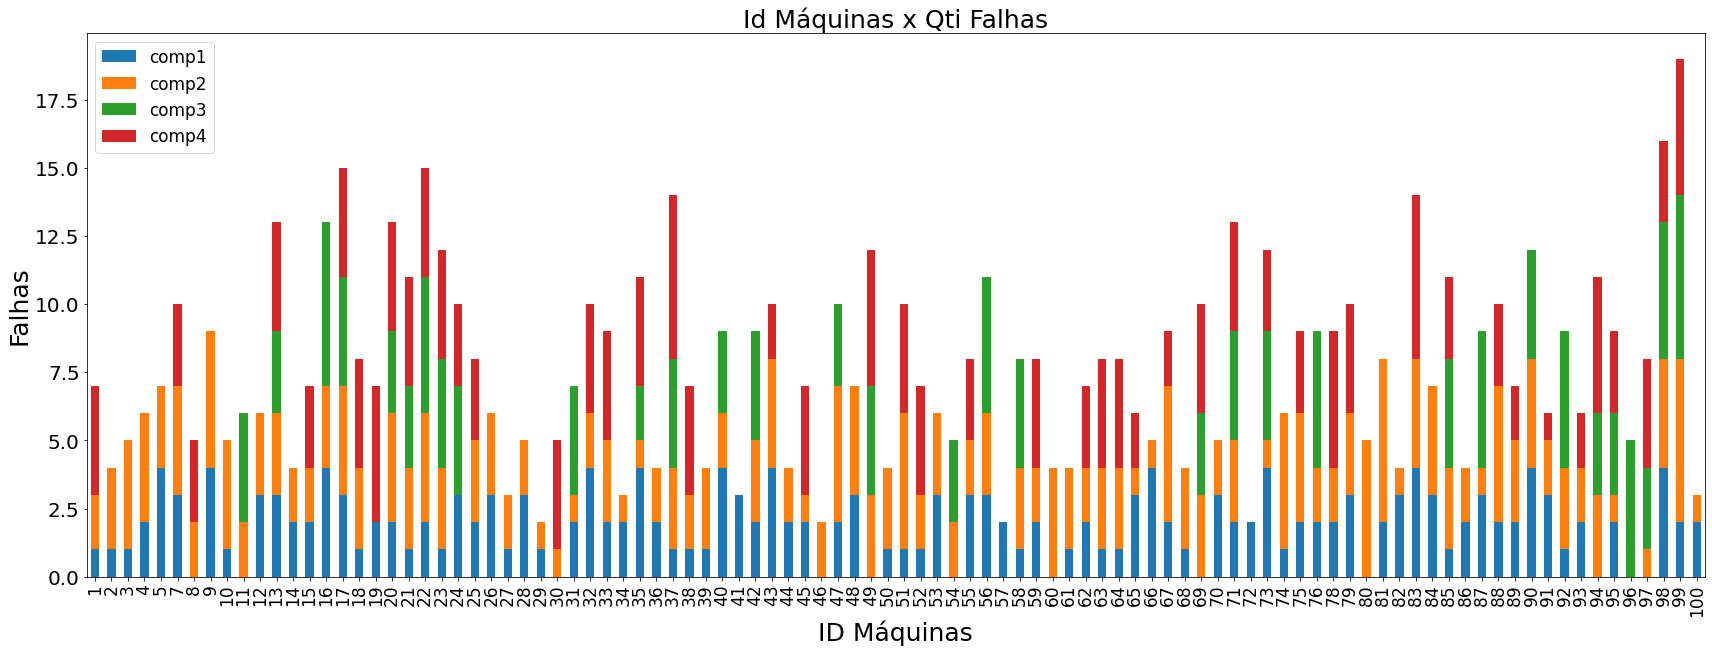

In [43]:
ax = falhas_pivot.plot(stacked = True, kind = '%%bashr', figsize=(29,10), fontsize = 14)
ax.set_xlabel("ID Máquinas", fontsize=25)
ax.set_ylabel("Falhas", fontsize=25)
ax.set_title("Id Máquinas x Qti Falhas", fontsize = 25)
plt.legend(fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 20)

plt.show()


In [44]:
dfmerge

,datetime,machineID,volt,rotate,pressure,vibration,model,age,model1,model2,...,Manutenção_comp3,Manutenção_comp4,Falha_comp1,Falha_comp2,Falha_comp3,Falha_comp4,Manutenção,Erro,Falha,date
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,False,False,...,False,False,False,False,False,False,False,False,False,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877204,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,model4,5,False,False,...,False,False,False,False,False,False,False,False,False,2016-01-01
877205,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,model4,5,False,False,...,False,False,False,False,False,False,False,False,False,2016-01-01
877206,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,model4,5,False,False,...,False,False,False,False,False,False,False,False,False,2016-01-01
877207,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,model4,5,False,False,...,False,False,False,False,False,False,False,False,False,2016-01-01


In [45]:
falhas_tempo = dfmerge.groupby(["date","machineID", "Falha"]).size().reset_index()
falhas_tempo.columns = ["Data","machineID" ,"Falha", "Contagem"]
falhas_tempo_pivot = pd.pivot(falhas_tempo, index = "Data", columns = ["machineID","Falha"], values = "Contagem")
falhas_tempo_pivot


machineID,1,2,3,4,5,6,7,8,9,10,...,93,2,31,72,53,39,68,26,13,34
Falha,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
Data,,,,,,,,,,,,,,,,,,,,,
2015-01-01,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,23.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-28,24.0,25.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-29,24.0,23.0,24.0,24.0,24.0,24.0,24.0,24.0,25.0,24.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


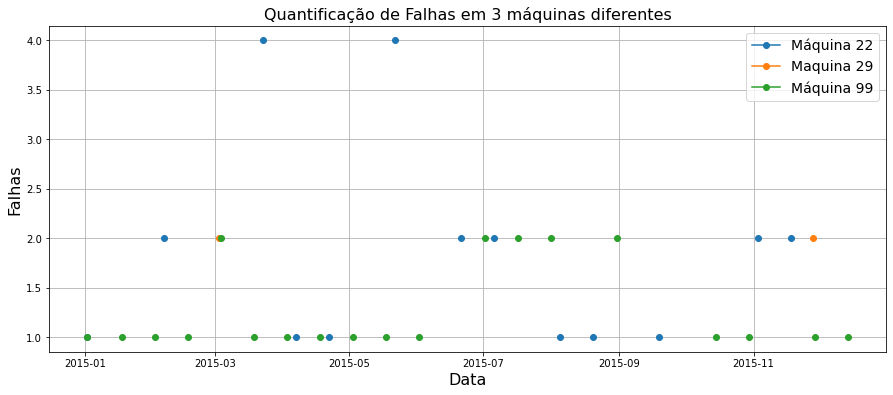

In [46]:
ax = falhas_tempo_pivot[[(22,True),(29,True), (99,True)]].plot(figsize=(15, 6),  marker = "o", grid = True)
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Falhas", fontsize=16)
ax.set_title("Quantificação de Falhas em 3 máquinas diferentes", fontsize = 16)
plt.legend(fontsize=14)

ax.legend(["Máquina 22", "Maquina 29", "Máquina 99"], fontsize=14)

plt.show()

# Analisando o dataset de troca de componentes

Text(0.5, 1.0, 'Ocorrências de Manutenção x Peças substituidas na Manutenção')

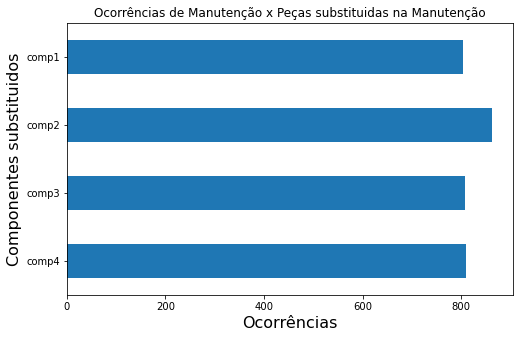

In [47]:
ax = df2["comp"].value_counts().sort_index(ascending = False).plot(stacked = True, kind = "barh", figsize=(8,5), title = "Troca de componentes")
ax.set_xlabel("Ocorrências", fontsize=16)
ax.set_ylabel("Componentes substituidos", fontsize=16)
ax.set_title("Ocorrências de Manutenção x Peças substituidas na Manutenção")

In [48]:
maint_sum = df2.groupby(["machineID", "comp"]).size().reset_index()
maint_sum.columns = ["machineID", "Manutenção Componente", "Contagem"]
maint_sum_pivot = pd.pivot(maint_sum, index="machineID", columns= "Manutenção Componente", values = "Contagem")
maint_sum_pivot

Manutenção Componente,comp1,comp2,comp3,comp4
machineID,,,,
1,11,9,8,9
2,7,9,6,10
3,9,12,7,9
4,8,7,8,10
5,8,11,9,7
...,...,...,...,...
96,8,6,8,11
97,9,11,6,8
98,9,10,7,11


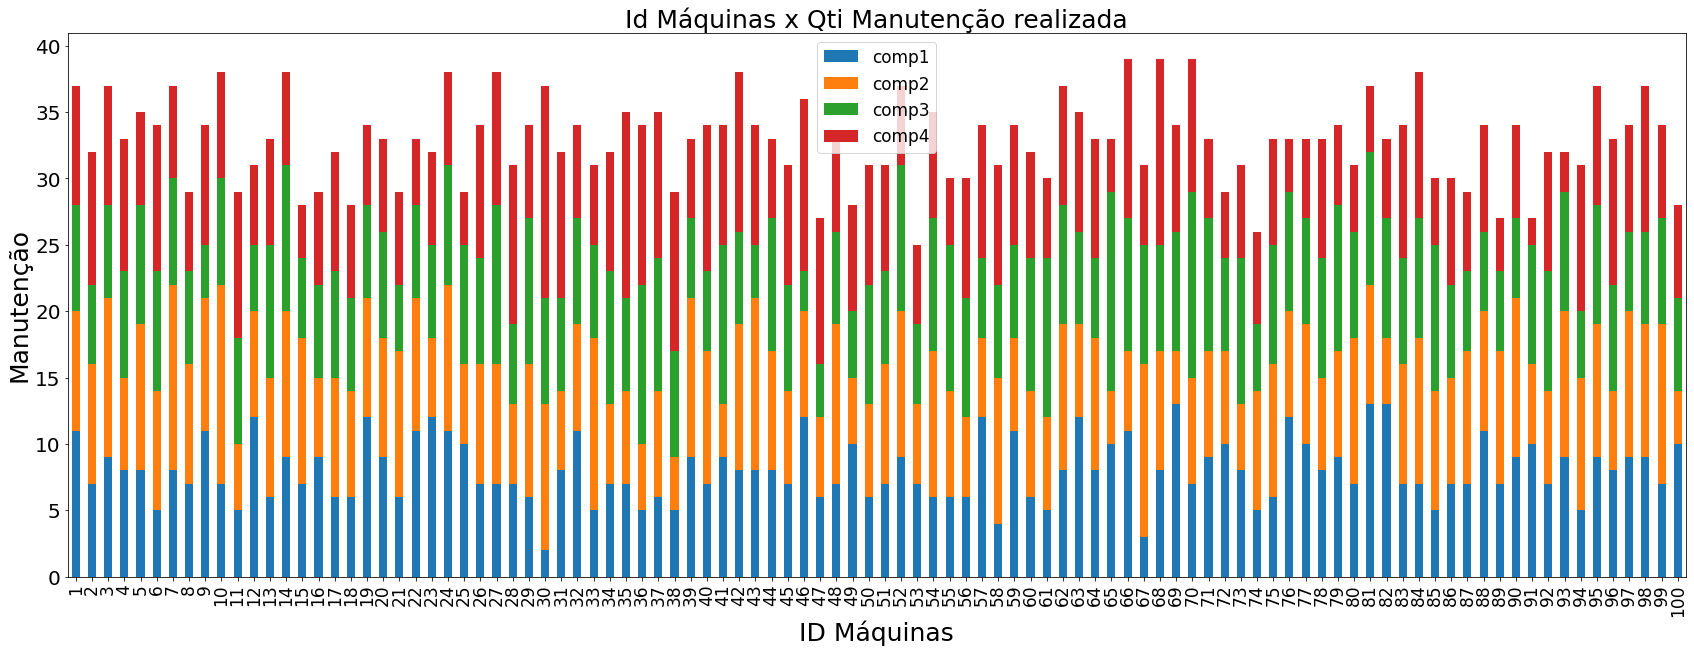

In [49]:
ax = maint_sum_pivot.plot(stacked = True, kind = 'bar', figsize = (29,10), fontsize = 14)
ax.set_xlabel("ID Máquinas", fontsize=25)
ax.set_ylabel("Manutenção", fontsize=25)
plt.legend(fontsize=14)
ax.set_title("Id Máquinas x Qti Manutenção realizada", fontsize = 25)
plt.legend(fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 20)

plt.show()


In [50]:
manutenção_tempo = dfmerge.groupby(["date","machineID", "Manutenção"]).size().reset_index()
manutenção_tempo.columns = ["Data","machineID" ,"Manutenção", "Contagem"]
manutenção_tempo_pivot = pd.pivot(manutenção_tempo, index = "Data", columns = ["machineID","Manutenção"], values = "Contagem")
manutenção_tempo_pivot


machineID,1,2,3,4,5,6,7,8,9,10,...,33,39,58,93,9,25,95,46,13,80
Manutenção,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
Data,,,,,,,,,,,,,,,,,,,,,
2015-01-01,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,23.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-28,24.0,25.0,24.0,23.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-29,24.0,23.0,24.0,24.0,24.0,24.0,24.0,24.0,23.0,24.0,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


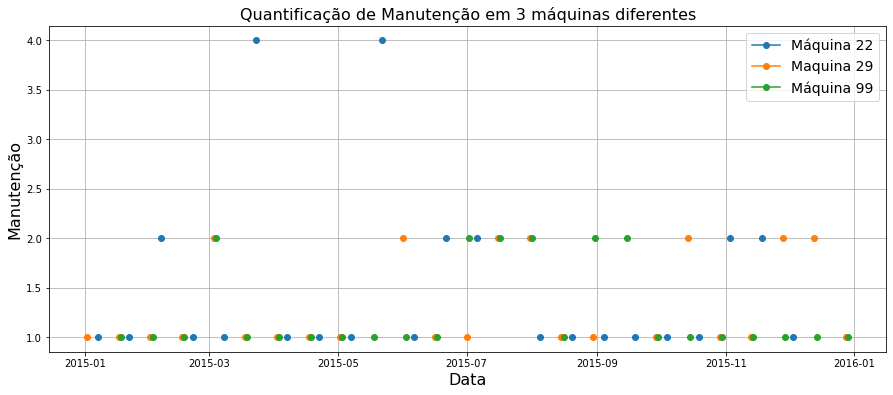

In [51]:
ax = manutenção_tempo_pivot[[(22,True),(29,True), (99,True)]].plot(figsize=(15, 6),  marker = "o", grid = True)
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Manutenção", fontsize=16)
ax.set_title("Quantificação de Manutenção em 3 máquinas diferentes", fontsize = 16)
plt.legend(fontsize=14)

plt.legend(fontsize=14)
ax.legend(["Máquina 22", "Maquina 29", "Máquina 99"], fontsize=14)
plt.show()

# Analisando as caracteristica das máquinas

Text(0.5, 1.0, 'Quantidade x Modelo de máquinas')

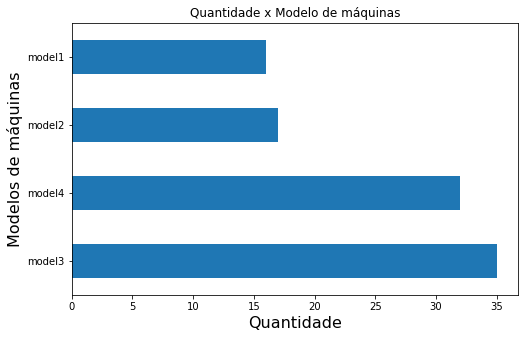

In [52]:
ax = df5["model"].value_counts().sort_values(ascending=False).plot(stacked = True, kind = "barh", figsize=(8,5), title = "Tipos de máquinas")
ax.set_xlabel("Quantidade", fontsize=16)
ax.set_ylabel("Modelos de máquinas", fontsize=16)
ax.set_title("Quantidade x Modelo de máquinas")

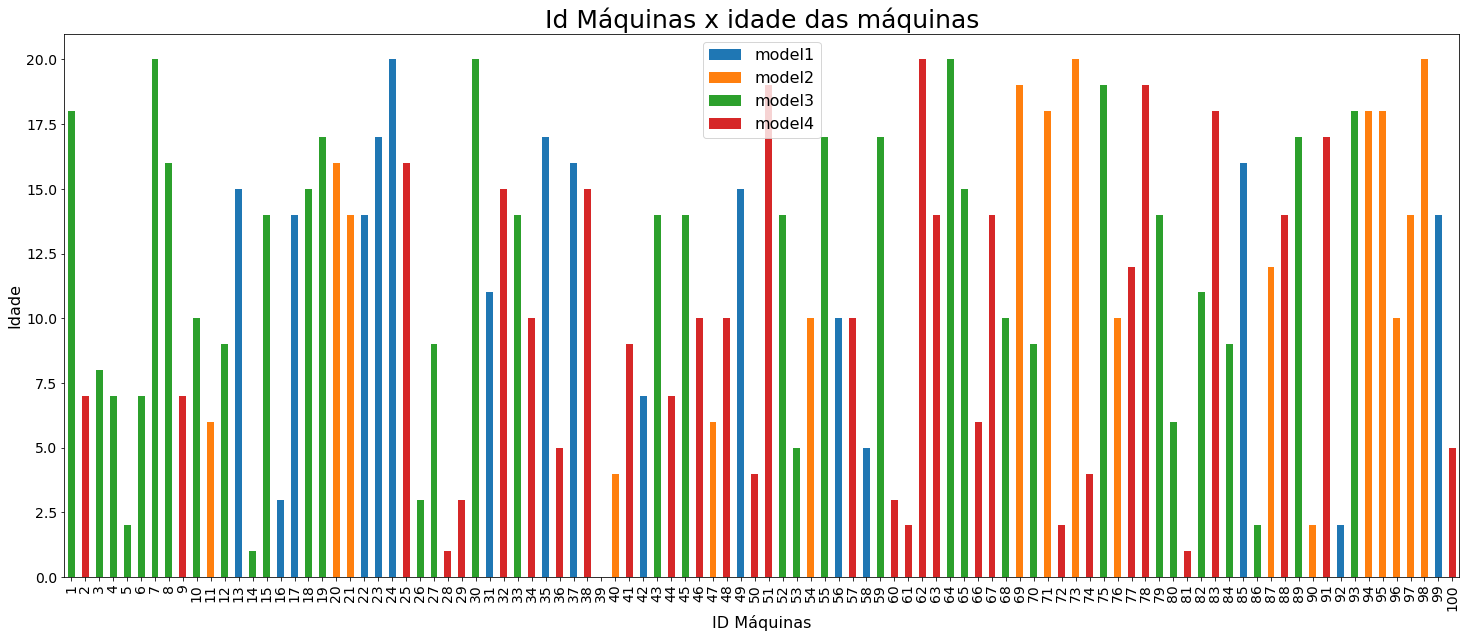

In [53]:
fig, ax = plt.subplots(figsize=(25, 10))

df5.groupby(["machineID", "model"])["age"].sum().unstack().plot(kind="bar", stacked=True, ax=ax, fontsize = 14)

ax.set_xlabel("ID Máquinas", fontsize=16)
ax.set_ylabel("Idade", fontsize=16)
ax.set_title("Id Máquinas x idade das máquinas", fontsize = 25)
ax.legend(fontsize=16)

plt.show()

In [54]:
%%time

# Importar bibliotecas necessárias
import pandas as pd

# Ler o arquivo de dados (supondo que esteja em formato CSV)
df = dfmerge.copy()
df = df[df["machineID"] == 1]

# Obter o número total de linhas no DataFrame
num_linhas = len(df)

# Definir a coluna que você deseja verificar
coluna_verificar = 'Erro'
coluna_verificar2= "Manutenção"

# Inicializar uma lista vazia para armazenar os resultados
resultados= []
resultados2 = []
resultados3 = []
soma = []
valor = 0
soma2 = []
soma3 = []

# Percorrer as linhas do DataFrame
for i in range(num_linhas):
    # Verificar as últimas 24 linhas (ou menos, se não houver 24 linhas anteriores)
    inicio = max(0, i - 168)
    inicio2 = max(0, i - 168)
    ultimas_linhas = df[coluna_verificar].iloc[inicio:i]
    ultimas_linhas2 = df[coluna_verificar2].iloc[inicio2:i]

    # Verificar se há algum valor "True" nas últimas linhas
    if ultimas_linhas.any() and df["Falha"][i] == True:
        resultados.append(True)
    
    else:
        resultados.append(False)
        
    if ultimas_linhas2.any() and df["Falha"][i] == True:
        resultados2.append(True)
    
    else:
        resultados2.append(False)
    
    if ultimas_linhas.any() and df["Falha"][i] == True and ultimas_linhas2.any():
        resultados3.append(True)
    else:
        resultados3.append(False)
        
    if ultimas_linhas.any():
        soma.append(valor)
        valor += 1
        print(f"aqui {valor}")
    else:
        soma.append(valor)
        print(f"aqui2 {valor}")
        valor = 0

# Adicionar os resultados como uma nova coluna no DataFrame
df['Falha_c_erro1sem'] = resultados
df["Falha_c_man1sem"] = resultados2
df["Falha_c_erro_man_1sem"] = resultados3
df["Erro_1sem"] = soma

# Visualizar o DataFrame atualizado
print(df)


aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui 1
aqui 2
aqui 3
aqui 4
aqui 5
aqui 6
aqui 7
aqui 8
aqui 9
aqui 10
aqui 11
aqui 12
aqui 13
aqui 14
aqui 15
aqui 16
aqui 17
aqui 18
aqui 19
aqui 20
aqui 21
aqui 22
aqui 23
aqui 24
aqui 25
aqui 26
aqui 27
aqui 28
aqui 29
aqui 30
aqui 31
aqui 32
aqui 33
aqui 34
aqui 35
aqui 36
aqui 37
aqui 38
aqui 39
aqui 40
aqui 41
aqui 42
aqui 43
aqui 44
aqui 45
aqui 46
aqui 47
aqui 48
aqui 49
aqui 50
aqui 51
aqui 52
aqui 53
aqui 54
aqui 55
aqui 56
aqui 57
aqui 58
aqui 59
aqui 60
aqui 61
aqui 62
aqui 63
aqui 64
aqui 65
aqui 66
aqui 67
aqui 68
aqui 69
aqui 70
aqui 71
aqui 72
aqui 73
aqui 74
aqui 75
aqui 76
a

aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0


aqui 330
aqui 331
aqui 332
aqui 333
aqui 334
aqui 335
aqui 336
aqui 337
aqui 338
aqui 339
aqui 340
aqui 341
aqui 342
aqui 343
aqui 344
aqui 345
aqui 346
aqui 347
aqui 348
aqui 349
aqui 350
aqui 351
aqui 352
aqui 353
aqui 354
aqui 355
aqui 356
aqui 357
aqui 358
aqui 359
aqui 360
aqui 361
aqui 362
aqui 363
aqui 364
aqui 365
aqui 366
aqui 367
aqui 368
aqui 369
aqui 370
aqui 371
aqui 372
aqui 373
aqui 374
aqui 375
aqui 376
aqui 377
aqui 378
aqui 379
aqui 380
aqui 381
aqui 382
aqui 383
aqui 384
aqui 385
aqui 386
aqui 387
aqui 388
aqui 389
aqui 390
aqui 391
aqui 392
aqui 393
aqui 394
aqui 395
aqui 396
aqui 397
aqui 398
aqui 399
aqui 400
aqui 401
aqui 402
aqui 403
aqui 404
aqui 405
aqui 406
aqui 407
aqui 408
aqui 409
aqui 410
aqui 411
aqui 412
aqui 413
aqui 414
aqui 415
aqui 416
aqui 417
aqui 418
aqui 419
aqui 420
aqui 421
aqui 422
aqui 423
aqui 424
aqui 425
aqui 426
aqui 427
aqui 428
aqui 429
aqui 430
aqui 431
aqui 432
aqui 433
aqui 434
aqui 435
aqui 436
aqui 437
aqui2 437
aqui2 0
aqui2 0
aq

aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui 1
aqui 2
aqui 3
aqui 4
aqui 5
aqui 6
aqui 7
aqui 8
aqui 9
aqui 10
aqui 11
aqui 12
aqui 13
aqui 14
aqui 15
aqui 16
aqui 17
aqui 18
aqui 19
aqui 20
aqui 21
aqui 22
aqui 23
aqui 24
aqui 25
aqui 26
aqui 27
aqui 28
aqui 29
aqui 30
aqui 31
aqui 32
aqui 33
aqui 34
aqui 35
aqui 36
aqui 37
aqui 38
aqui 39
aqui 40
aqui 41
aqui 42
aqui 43
aqui 44
aqui 45
aqui 46
aqui 47
aqui 48
aqui 49
aqui 50
aqui 51
aqui 52
aqui 53
aqui 54
aqui 55
aqui 56
aqui 57
aqui 58
aqui 59
aqui 60
aqui 61
aqui 62
aqui 63
aqui 64
aqui 65
aqui 66
aqui 67
aqui 68
aqui 69
aqui 70
aqui 71
aqui 72
aqui 73
aqui 74
aqui 75
aqui 76
aqui 77
aqui 78
aqui 79
aqui 80
aqui 81
aqui 82
aqui 83
aqui 84
aqui 85
aqui 86
aqui 87
aqui 88
aqui 89
aqui 90
aqui 91
aqui 92
aqui 93
aqui 94
aqui 95
aqui 96
aqui 97
aqui 98
aqui 99
aqui 100
aqui 101

aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0


aqui 65
aqui 66
aqui 67
aqui 68
aqui 69
aqui 70
aqui 71
aqui 72
aqui 73
aqui 74
aqui 75
aqui 76
aqui 77
aqui 78
aqui 79
aqui 80
aqui 81
aqui 82
aqui 83
aqui 84
aqui 85
aqui 86
aqui 87
aqui 88
aqui 89
aqui 90
aqui 91
aqui 92
aqui 93
aqui 94
aqui 95
aqui 96
aqui 97
aqui 98
aqui 99
aqui 100
aqui 101
aqui 102
aqui 103
aqui 104
aqui 105
aqui 106
aqui 107
aqui 108
aqui 109
aqui 110
aqui 111
aqui 112
aqui 113
aqui 114
aqui 115
aqui 116
aqui 117
aqui 118
aqui 119
aqui 120
aqui 121
aqui 122
aqui 123
aqui 124
aqui 125
aqui 126
aqui 127
aqui 128
aqui 129
aqui 130
aqui 131
aqui 132
aqui 133
aqui 134
aqui 135
aqui 136
aqui 137
aqui 138
aqui 139
aqui 140
aqui 141
aqui 142
aqui 143
aqui 144
aqui 145
aqui 146
aqui 147
aqui 148
aqui 149
aqui 150
aqui 151
aqui 152
aqui 153
aqui 154
aqui 155
aqui 156
aqui 157
aqui 158
aqui 159
aqui 160
aqui 161
aqui 162
aqui 163
aqui 164
aqui 165
aqui 166
aqui 167
aqui 168
aqui 169
aqui 170
aqui 171
aqui 172
aqui 173
aqui 174
aqui 175
aqui 176
aqui 177
aqui 178
aqui 179


aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui 1
aqui 2
aqui 3
aqui 4
aqui 5
aqui 6
aqui 7
aqui 8
aqui 9
aqui 10
aqui 11
aqui 12
aqui 13
aqui 14
aqui 15
aqui 16
aqui 17
aqui 18
aqui 19
a

aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0
aqui2 0


In [55]:
%%time

# Importar bibliotecas necessárias
import pandas as pd

# Ler o arquivo de dados (supondo que esteja em formato CSV)
df = dfmerge.copy()
#df = df[df["machineID"] == 1]

# Obter o número total de linhas no DataFrame
num_linhas = len(df)

# Definir a coluna que você deseja verificar
coluna_verificar = 'Erro'
coluna_verificar2= "Manutenção"

# Inicializar uma lista vazia para armazenar os resultados
resultados= []
resultados2 = []
resultados3 = []

soma = []
valor = 0

soma2 = []
valor2 = 0

soma3 = []
valor3 = 0

somae = []
somae2 =[]

cont = 0
cont2 = 0
j = 0 

# Percorrer as linhas do DataFrame
for i in range(num_linhas):
    # Verificar as últimas 24 linhas (ou menos, se não houver 24 linhas anteriores)
    inicio = max(0, i - 1080)
    inicio2 = max(0, i - 1080)
    
    if j == 0 :    
        ultimas_linhas = df[coluna_verificar].iloc[inicio:i]
        ultimas_linhas2 = df[coluna_verificar2].iloc[inicio2:i]
    else:
        ultimas_linhas = df[coluna_verificar].iloc[j:i]
        ultimas_linhas2 = df[coluna_verificar2].iloc[j:i]
    
    if ultimas_linhas.any():
        valor += 1
        soma.append(valor)
        #print(f"aqui {valor}")
        
        if df["Falha"][i] or df["Manutenção"][i]:
            #print(f"aquivalor{i-j}")
            valor = 0
            j = i
            #cont = 0
            #print(j)
    
    else:
        soma.append(valor)
        #somae.append(cont)
        #print(f"aqui2 {valor}")
        valor = 0
        #cont = 0
    
    if df[coluna_verificar][i] == True:
            cont+=1
            #print(f"Deubao{cont}")
            somae.append(cont)
    
    else:
        if cont > 0:
            somae.append(cont)
            if df["Falha"][i] or df["Manutenção"][i]:
                cont = 0 
                pass
            pass
        else:
            somae.append(cont)

        
    
    if ultimas_linhas2.any():
        valor2 += 1
        soma2.append(valor2)
        #print(f"aqui3 {valor2}")
        if df["Falha"][i] or (i-j >= 48):
            valor2 = 0
            j = i
            cont2 = 0
    else:
        soma2.append(valor2)
        #print(f"aqui4 {valor2}")
        valor2 = 0
        
    if df[coluna_verificar2][i] == True:
        if df["Falha"][i]:
            cont2 = 0
        else:
            cont2+=1
            #print(f"Deubao2{cont2}")
        somae2.append(cont2)
    
    else:
        if cont2 > 0:
            pass
        else:
            cont2 = 0
        somae2.append(cont2)
        
    if (ultimas_linhas.any()) & (ultimas_linhas2.any()):
        valor3 += 1
        soma3.append(valor3)
        #print(f"aqui5 {valor3}")
        if df["Falha"][i] or (i-j >= 168):
            valor3 = 0
            j = i
    else:
        soma3.append(valor3)
        #print(f"aqui6 {valor3}")
        valor3 = 0

# Adicionar os resultados como uma nova coluna no DataFrame
df["Erro_7d"] = soma
df["manutenção_2d"] = soma2
df["Erro_manut_2d"] = soma3
df["cont_erro"] = somae
df["cont_manut"] = somae2

# Visualizar o DataFrame atualizado
print(df)


                  datetime  machineID        volt      rotate    pressure  \
0      2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1      2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2      2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3      2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4      2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   
...                    ...        ...         ...         ...         ...   
877204 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
877205 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
877206 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
877207 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
877208 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration   model  age  model1  model2  ...  Falha_comp4  Manutençã

In [56]:
%%time

# Importar bibliotecas necessárias
import pandas as pd

# Ler o arquivo de dados (supondo que esteja em formato CSV)
df = dfmerge.copy()
#df = df[df["machineID"] == 1]

# Obter o número total de linhas no DataFrame
num_linhas = len(df)

# Definir a coluna que você deseja verificar
coluna_verificar = 'Erro'
coluna_verificar2= "Manutenção"

# Inicializar uma lista vazia para armazenar os resultados
resultados= []
resultados2 = []
resultados3 = []

soma = []
valor = 0

soma2 = []
valor2 = 0

soma3 = []
valor3 = 0

somae = []
somae2 =[]

cont = 0
cont2 = 0
j = 0 
k = 0

# Percorrer as linhas do DataFrame
for i in range(num_linhas):
    # Verificar as últimas 24 linhas (ou menos, se não houver 24 linhas anteriores)
    inicio = max(0, i - 1080)
    inicio2 = max(0, i - 1080)
    
    if j == 0 :    
        ultimas_linhas = df[coluna_verificar].iloc[inicio:i]
        
    elif j > 0:
        ultimas_linhas = df[coluna_verificar].iloc[j:i]
    if k == 0 :
        ultimas_linhas2 = df[coluna_verificar2].iloc[inicio2:i]
    elif k > 0 :
        ultimas_linhas2 = df[coluna_verificar2].iloc[k:i]

    if ultimas_linhas.any():
        valor += 1
        #print(f"i:{i}, j:{j}, valor:{valor}, {ultimas_linhas.any()}")
        soma.append(valor)
        #print(f"aqui é {j-i} do valor1")
        #print(f"aqui {valor}")
        
        if df["Falha"][i] or df["Manutenção"][i] or (i-j >=1080):
            #print(f"{j},{i} AQUi1")
            #print(f"aqui é i:{i} e j:{j} e valor:{valor} do valor1")
            #print(f"aquivalor{i-j}")
            valor = 0
            j = i
            #cont = 0
            #print(j)
    
    else:
        soma.append(valor)
        #somae.append(cont)
        #print(f"aqui2 {valor}")
        j=i
        valor = 0
        
    if df[coluna_verificar][i] == True:
        cont+=1
        #print(f"Deubao{cont}")
        somae.append(cont)
    
    else:
        if cont > 0:
            somae.append(cont)
            if df["Falha"][i] or df["Manutenção"][i]:
                cont = 0 
                pass
            pass
        else:
            somae.append(cont)
        
    if ultimas_linhas2.any():
        valor2 += 1
        #print(f"i:{i}, k:{k}, valor:{valor2}, {ultimas_linhas2.any()}")
        soma2.append(valor2)
        #print(f"aqui é {j-i} do valor1")
        #print(f"aqui {valor}")
        
        if df["Falha"][i] or df["Manutenção"][i] or (i-k >=1080):
            #print(f"{j},{i} AQUi1")
            #print(f"aqui é i:{i} e k:{k} e valor:{valor2} do valor2")
            #print(f"aquivalor{i-j}")
            valor2 = 0
            k = i
            #cont = 0
            #print(j)
    
    else:
        soma2.append(valor2)
        #somae.append(cont)
        #print(f"aqui2 {valor}")
        k=i
        valor2 = 0
        
    if df[coluna_verificar2][i] == True:
        if df["Falha"][i]:
            cont2 = 0
        else:
            cont2+=1
            #print(f"Deubao2{cont2}")
        somae2.append(cont2)

    else:
        if cont2 > 0:
            pass
        else:
            cont2 = 0
        somae2.append(cont2)

        
df["Erro_7d"] = soma
df["manutenção_2d"] = soma2
#df["Erro_manut_2d"] = soma3
df["cont_erro"] = somae
df["cont_manut"] = somae2

# Visualizar o DataFrame atualizado
print(df)


                  datetime  machineID        volt      rotate    pressure  \
0      2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1      2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2      2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3      2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4      2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   
...                    ...        ...         ...         ...         ...   
877204 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
877205 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
877206 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
877207 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
877208 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration   model  age  model1  model2  ...  Falha_comp3  Falha_com

In [57]:
ultimas_linhas

877207    False
Name: Erro, dtype: bool

In [58]:
s = dtale.show(df)
s.open_browser()

In [59]:
#df.iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,29,30,31,32,33]]
df.iloc[:,[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]] = df.iloc[:,[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]].astype(int)
df.iloc[:,[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]

,model1,model2,model3,model4,Erro_error1,Erro_error2,Erro_error3,Erro_error4,Erro_error5,Manutenção_comp1,Manutenção_comp2,Manutenção_comp3,Manutenção_comp4,Falha_comp1,Falha_comp2,Falha_comp3,Falha_comp4,Manutenção,Erro,Falha
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877204,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
877205,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
877206,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
877207,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
# Criar uma lista com todos os números de 0 a 99
todos_os_valores = np.arange(100)

# Valores a serem removidos
valores_a_remover = [99, 22, 29]

# Remover os valores indesejados
valores_restantes = np.setdiff1d(todos_os_valores, valores_a_remover)

# Gerar a lista sem os valores removidos
lista = np.random.choice(valores_restantes, size=97, replace=False)
lista = list(lista)

# Imprimir a lista gerada
print(lista)

[28, 52, 91, 77, 82, 34, 26, 71, 62, 74, 6, 79, 51, 76, 75, 19, 85, 15, 63, 31, 2, 84, 48, 1, 92, 30, 4, 8, 32, 3, 86, 11, 35, 94, 36, 43, 89, 70, 64, 40, 55, 39, 58, 27, 24, 33, 73, 97, 7, 44, 25, 50, 61, 16, 38, 37, 45, 83, 17, 69, 68, 49, 60, 46, 90, 18, 96, 21, 95, 87, 72, 12, 5, 53, 78, 23, 80, 81, 54, 0, 93, 88, 13, 47, 20, 67, 42, 41, 9, 14, 65, 59, 98, 57, 10, 66, 56]


In [61]:
#lista = [13,60,17,56,50,14,69,98,84,45,68,86,25,57,48,52,87,95,78,11,53,9,18,88,16,51,65,63,44,58,79,38,43,6,85,89,67,2,93,24,33,31,49,70,20,75,61,62,28,3,55,81,42,1,41,66,40,59,5,82,97,80,64,47,30,27,91,72,94,0]
lista = [66, 3, 62, 64, 73, 30, 17, 5, 98, 19, 53, 69, 85, 1, 82, 15, 80, 55, 26, 95, 97, 54, 76, 61, 25, 43, 8, 0, 21, 89, 36, 96, 45, 38, 88, 71, 87, 83, 56, 32, 75, 37, 90, 16, 94, 20, 77, 79, 60, 27, 48, 40, 81, 68, 2, 18, 67, 23, 7, 52, 74, 93, 59, 63, 4, 70, 58, 44, 42, 12, 28, 31, 39, 24, 46, 72, 65, 92, 49, 47]

In [62]:
df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30,31]]

,machineID,volt,rotate,pressure,vibration,age,model1,model2,model3,model4,...,Erro_error5,Manutenção_comp1,Manutenção_comp2,Manutenção_comp3,Manutenção_comp4,Manutenção,Erro,Erro_7d,manutenção_2d,cont_erro
0,1,176.217853,418.504078,113.077935,45.087686,18,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,162.879223,402.747490,95.460525,43.413973,18,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,170.989902,527.349825,75.237905,34.178847,18,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,162.462833,346.149335,109.248561,41.122144,18,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,157.610021,435.376873,111.886648,25.990511,18,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859665,98,164.321319,447.495715,105.127837,52.249512,20,0,1,0,0,...,0,0,0,0,0,0,0,100,140,1
859666,98,180.410465,485.467071,117.467661,37.321110,20,0,1,0,0,...,0,0,0,0,0,0,0,101,141,1
859667,98,158.354201,389.828191,121.270784,38.201489,20,0,1,0,0,...,0,0,0,0,0,0,0,102,142,1
859668,98,193.754368,450.198921,127.851932,39.800055,20,0,1,0,0,...,0,0,0,0,0,0,0,103,143,1


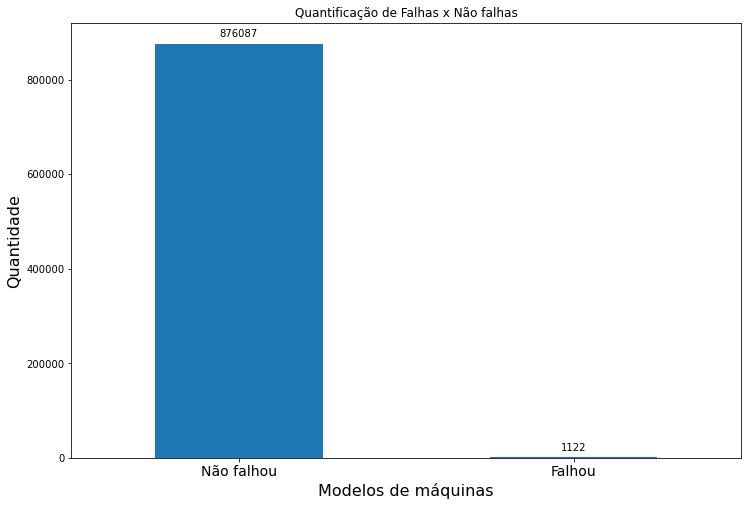

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Vamos supor que você tenha um DataFrame chamado df

# Seu código para criar o gráfico
ax = df["Falha"].value_counts().sort_values(ascending=False).plot(
    kind="bar", figsize=(12, 8), title="Quantidade de falhas"
)

# Configurações do gráfico
ax.set_xlabel("Modelos de máquinas", fontsize=16)
ax.set_ylabel("Quantidade", fontsize=16)
ax.set_title("Quantificação de Falhas x Não falhas")

# Adicionando os valores acima das barras
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Definindo os rótulos do eixo x
ax.set_xticklabels(["Não falhou", "Falhou"], rotation=0, fontdict = {'fontsize':14})

plt.show()

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn.metrics import classification_report


from sklearn.linear_model import LogisticRegression


from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import Bunch
import pandas as pd


# Regressão Logistica

In [65]:
def classification_report_df(y_true, y_pred, target_names=None, sample_weight=None, digits=2):
    # Gera o classification_report em formato de dicionário
    report_dict = classification_report(y_true, y_pred, target_names=target_names, sample_weight=sample_weight, output_dict=True)
    
    # Cria uma estrutura Bunch para facilitar a conversão em DataFrame
    bunch = Bunch(**report_dict)
    del bunch['accuracy']

    # Converte o Bunch em DataFrame
    df = pd.DataFrame(bunch).transpose()

    # Formata os números de acordo com a quantidade de dígitos desejados
    df = df.applymap(lambda x: round(x, digits) if isinstance(x, (int, float)) else x)

    return df


C:\Users\Matheus Keitaro\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Matheus Keitaro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



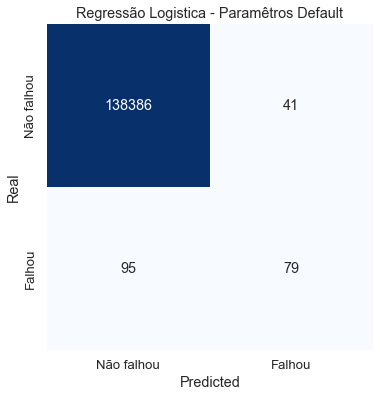

O valor da curva AUC:  0.7268634017564676
O valor da acurácia é:  0.9990187660983687
O valor de precision é:  0.6583333333333333
O valor de recall é : 0.4540229885057471
O valor do f1-score é:  0.5374149659863946


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,138427.0
Falhou,0.66,0.45,0.54,174.0
macro avg,0.83,0.73,0.77,138601.0
weighted avg,1.00,1.00,1.00,138601.0


In [66]:
X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Crie uma instância do modelo de regressão logística
regression_model1 = LogisticRegression()

# Treine o modelo com os dados de treinamento
regression_model1.fit(X_train, y_train)


# Faça previsões utilizando o conjunto de teste
y_pred = regression_model1.predict(X_test)

# Calcule o coeficiente de determinação (R²)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
f1score = f1_score(y_test,y_pred)

class_rep2 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Regressão Logistica - Paramêtros Default')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()


# Tunning Regressão Logistica

In [ ]:
from sklearn.metrics import r2_score, recall_score, precision_score, roc_auc_score

X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie uma instância do modelo de regressão logística
regression_model5 = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 125,150],
}

grid_search = GridSearchCV(regression_model5, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model2 = grid_search.best_estimator_
y_pred = best_model2.predict(X_test)

r2 = r2_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
test_accuracy = best_model2.score(X_test, y_test)

confusion_mat = confusion_matrix(y_test, y_pred)

print("Coeficiente de Determinação (R²):", r2)
print("Coeficiente AUC:", auc)
print("Acurácia:", test_accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("Matriz de Confusão:")
print(confusion_mat)

C:\Users\Matheus Keitaro\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



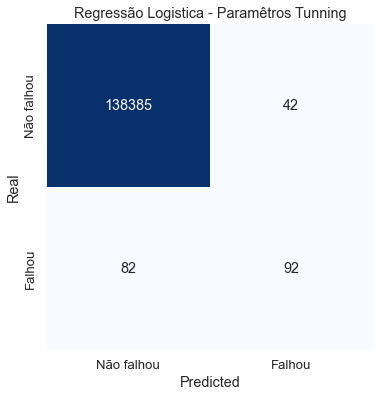

O valor da curva AUC:  0.7642161115834405
O valor da acurácia é:  0.9991053455602773
O valor de precision é:  0.6865671641791045
O valor de recall é : 0.5287356321839081
O valor do f1-score é:  0.5974025974025974


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.0,138427.0
Falhou,0.69,0.53,0.6,174.0
macro avg,0.84,0.76,0.8,138601.0
weighted avg,1.00,1.00,1.0,138601.0


In [67]:
X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Crie uma instância do modelo de regressão logística
regression_model2 = LogisticRegression(C = 1, max_iter = 150, penalty = "l1", solver = "liblinear")

# Treine o modelo com os dados de treinamento
regression_model2.fit(X_train, y_train)


# Faça previsões utilizando o conjunto de teste
y_pred = regression_model2.predict(X_test)

# Calcule o coeficiente de determinação (R²)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
f1score = f1_score(y_test,y_pred)

class_rep5 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Regressão Logistica - Paramêtros Tunning')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep5.head()


C:\Users\Matheus Keitaro\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



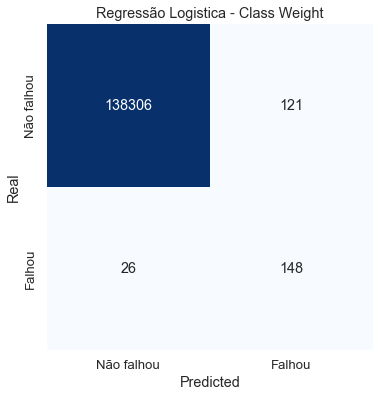

O valor da curva AUC:  0.9248503028568359
O valor da acurácia é:  0.9989394015916191
O valor de precision é:  0.550185873605948
O valor de recall é : 0.8505747126436781
O valor do f1-score é:  0.6681715575620767


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,138427.0
Falhou,0.55,0.85,0.67,174.0
macro avg,0.77,0.92,0.83,138601.0
weighted avg,1.00,1.00,1.00,138601.0


Executing shutdown due to inactivity...


2023-10-14 17:38:30,473 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2023-10-14 17:38:51,008 - INFO     - Executing shutdown...
C:\Users\Matheus Keitaro\anaconda3\lib\site-packages\dtale\app.py:397: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



In [102]:
X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Crie uma instância do modelo de regressão logística
class_weights = {0: 1, 1:3}  # Por exemplo, dando mais peso à classe 1


# Crie uma instância do modelo de regressão logística
regression_model3 = LogisticRegression(C = 1, max_iter = 150, penalty = "l1", solver = "liblinear", class_weight= class_weights)

# Treine o modelo com os dados de treinamento
regression_model3.fit(X_train, y_train)


# Faça previsões utilizando o conjunto de teste
y_pred = regression_model3.predict(X_test)

# Calcule o coeficiente de determinação (R²)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
f1score = f1_score(y_test,y_pred)

class_rep6 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Regressão Logistica - Class Weight')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep6.head()


# VALIDAÇÃO REGRESSÃO LOGISTICA

# Model1

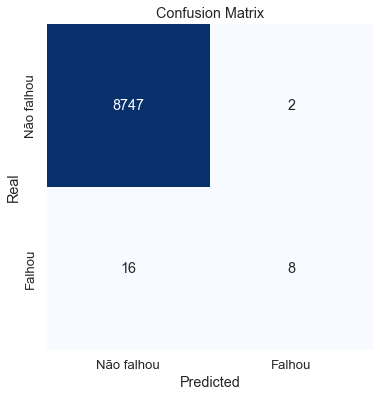

O valor da curva AUC:  0.6665523678896635
O valor da acurácia é:  0.9979482503134618
O valor de precision é:  0.8
O valor de recall é : 0.3333333333333333
O valor do f1-score é:  0.47058823529411764


,precision,recall,f1-score,support
Não falhou,1.0,1.00,1.00,8749.0
Falhou,0.8,0.33,0.47,24.0
macro avg,0.9,0.67,0.73,8773.0
weighted avg,1.0,1.00,1.00,8773.0


In [69]:
X_new = df[df["machineID"]==99].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==99].iloc[:,[27]].values

y_pred_mod = regression_model1.predict(X_new)

# Calcule o coeficiente de determinação (R²)
#r2 = r2_score(y_new, y_pred_mod)
accuracy = accuracy_score(y_new, y_pred_mod)
precision = precision_score(y_new, y_pred_mod)
recall = recall_score(y_new, y_pred_mod)
auc = roc_auc_score(y_new, y_pred_mod)
confusion = confusion_matrix(y_new, y_pred_mod)
f1score = f1_score(y_new, y_pred_mod)

class_rep2 = classification_report_df(y_new, y_pred_mod, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()



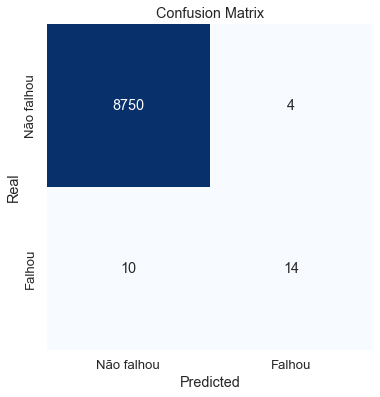

O valor da curva AUC:  0.7914381996801463
O valor da acurácia é:  0.9984051036682615
O valor de precision é:  0.7777777777777778
O valor de recall é : 0.5833333333333334
O valor do f1-score é:  0.6666666666666666


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,207627.0
Falhou,0.52,0.81,0.64,274.0
macro avg,0.76,0.90,0.82,207901.0
weighted avg,1.00,1.00,1.00,207901.0


In [70]:
X_new = df[df["machineID"]==22].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==22].iloc[:,[27]].values


y_pred_mod = regression_model1.predict(X_new)

# Calcule o coeficiente de determinação (R²)
accuracy = accuracy_score(y_new, y_pred_mod)
precision = precision_score(y_new, y_pred_mod)
recall = recall_score(y_new, y_pred_mod)
auc = roc_auc_score(y_new, y_pred_mod)
confusion = confusion_matrix(y_new, y_pred_mod)
f1score = f1_score(y_new, y_pred_mod)

class_rep2 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()


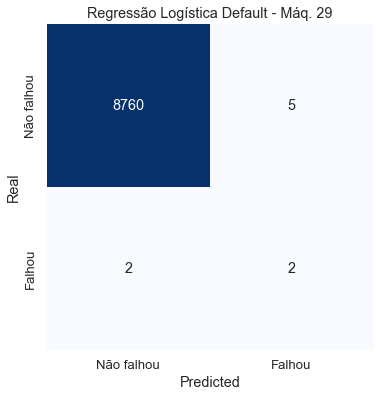

O valor da curva AUC:  0.7497147746719909
O valor da acurácia é:  0.9992017333789486
O valor de precision é:  0.2857142857142857
O valor de recall é : 0.5
O valor do f1-score é:  0.36363636363636365


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8765.0
Falhou,0.29,0.50,0.36,4.0
macro avg,0.64,0.75,0.68,8769.0
weighted avg,1.00,1.00,1.00,8769.0


In [71]:
X_new = df[df["machineID"]==29].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==29].iloc[:,[27]].values


y_pred_mod = regression_model1.predict(X_new)

# Calcule o coeficiente de determinação (R²)
accuracy = accuracy_score(y_new, y_pred_mod)
precision = precision_score(y_new, y_pred_mod)
recall = recall_score(y_new, y_pred_mod)
auc = roc_auc_score(y_new, y_pred_mod)
confusion = confusion_matrix(y_new, y_pred_mod)
f1score = f1_score(y_new, y_pred_mod)

class_rep2 = classification_report_df(y_new, y_pred_mod, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Regressão Logística Default - Máq. 29')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)
class_rep2.head()


# Model 2 

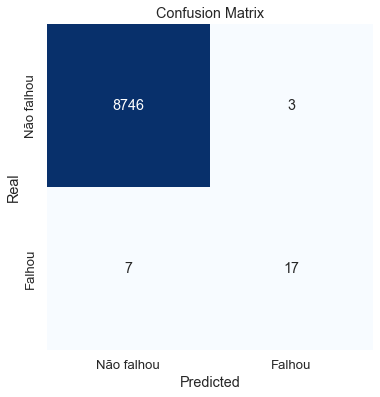

O valor da curva AUC:  0.8539952185011621
O valor da acurácia é:  0.9988601390630343
O valor de precision é:  0.85
O valor de recall é : 0.7083333333333334
O valor do f1-score é:  0.7727272727272727


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,207627.0
Falhou,0.52,0.81,0.64,274.0
macro avg,0.76,0.90,0.82,207901.0
weighted avg,1.00,1.00,1.00,207901.0


In [72]:
X_new = df[df["machineID"]==99].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==99].iloc[:,[27]].values

y_pred_mod = regression_model2.predict(X_new)

# Calcule o coeficiente de determinação (R²)
#r2 = r2_score(y_new, y_pred_mod)
accuracy = accuracy_score(y_new, y_pred_mod)
precision = precision_score(y_new, y_pred_mod)
recall = recall_score(y_new, y_pred_mod)
auc = roc_auc_score(y_new, y_pred_mod)
confusion = confusion_matrix(y_new, y_pred_mod)
f1score = f1_score(y_new, y_pred_mod)

class_rep2 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()


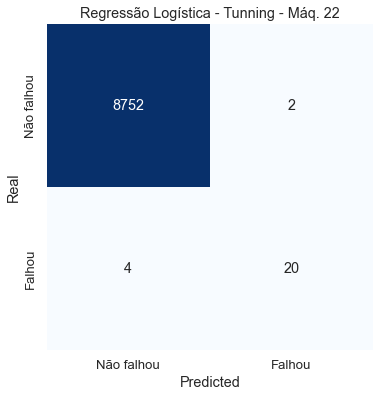

O valor da curva AUC:  0.9165524331734065
O valor da acurácia é:  0.9993164730006835
O valor de precision é:  0.9090909090909091
O valor de recall é : 0.8333333333333334
O valor do f1-score é:  0.8695652173913043


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8754.0
Falhou,0.91,0.83,0.87,24.0
macro avg,0.95,0.92,0.93,8778.0
weighted avg,1.00,1.00,1.00,8778.0


In [73]:
X_new = df[df["machineID"]==22].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==22].iloc[:,[27]].values

y_pred_mod = regression_model2.predict(X_new)

# Calcule o coeficiente de determinação (R²)
#r2 = r2_score(y_new, y_pred_mod)
accuracy = accuracy_score(y_new, y_pred_mod)
precision = precision_score(y_new, y_pred_mod)
recall = recall_score(y_new, y_pred_mod)
auc = roc_auc_score(y_new, y_pred_mod)
confusion = confusion_matrix(y_new, y_pred_mod)
f1score = f1_score(y_new, y_pred_mod)

class_rep2 = classification_report_df(y_new, y_pred_mod, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Regressão Logística - Tunning - Máq. 22')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()



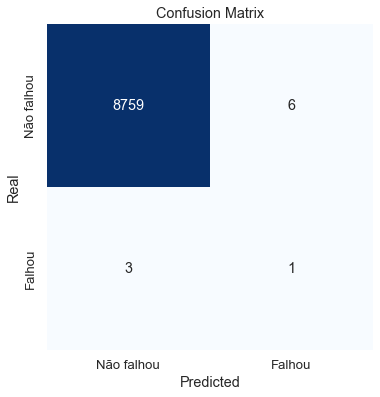

O valor da curva AUC:  0.624657729606389
O valor da acurácia é:  0.9989736572015053
O valor de precision é:  0.14285714285714285
O valor de recall é : 0.25
O valor do f1-score é:  0.18181818181818182


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8765.0
Falhou,0.14,0.25,0.18,4.0
macro avg,0.57,0.62,0.59,8769.0
weighted avg,1.00,1.00,1.00,8769.0


In [74]:
X_new = df[df["machineID"]==29].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==29].iloc[:,[27]].values

y_pred_mod = regression_model2.predict(X_new)

# Calcule o coeficiente de determinação (R²)
#r2 = r2_score(y_new, y_pred_mod)
accuracy = accuracy_score(y_new, y_pred_mod)
precision = precision_score(y_new, y_pred_mod)
recall = recall_score(y_new, y_pred_mod)
auc = roc_auc_score(y_new, y_pred_mod)
confusion = confusion_matrix(y_new, y_pred_mod)
f1score = f1_score(y_new, y_pred_mod)

class_rep2 = classification_report_df(y_new, y_pred_mod, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()



# model 3

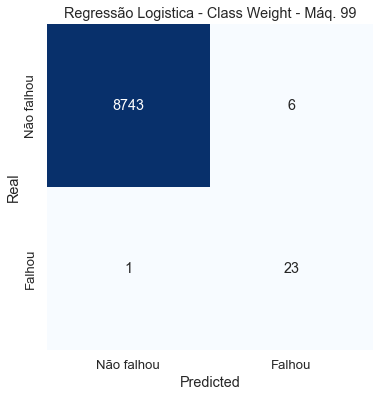

O valor da curva AUC:  0.9788237703356575
O valor da acurácia é:  0.999202097344124
O valor de precision é:  0.7931034482758621
O valor de recall é : 0.9583333333333334
O valor do f1-score é:  0.8679245283018867


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8749.0
Falhou,0.79,0.96,0.87,24.0
macro avg,0.90,0.98,0.93,8773.0
weighted avg,1.00,1.00,1.00,8773.0


In [75]:
X_new = df[df["machineID"]==99].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==99].iloc[:,[27]].values

y_pred_mod = regression_model3.predict(X_new)

# Calcule o coeficiente de determinação (R²)
#r2 = r2_score(y_new, y_pred_mod)
accuracy = accuracy_score(y_new, y_pred_mod)
precision = precision_score(y_new, y_pred_mod)
recall = recall_score(y_new, y_pred_mod)
auc = roc_auc_score(y_new, y_pred_mod)
confusion = confusion_matrix(y_new, y_pred_mod)
f1score = f1_score(y_new, y_pred_mod)

class_rep2 = classification_report_df(y_new, y_pred_mod, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Regressão Logistica - Class Weight - Máq. 99')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()



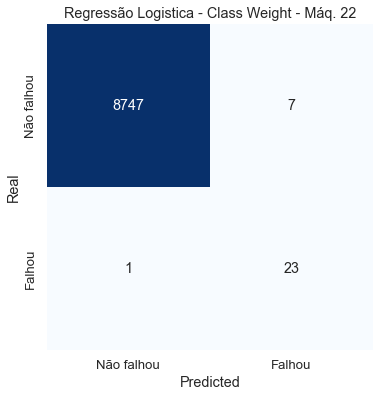

O valor da curva AUC:  0.9787668494402559
O valor da acurácia é:  0.999088630667578
O valor de precision é:  0.7666666666666667
O valor de recall é : 0.9583333333333334
O valor do f1-score é:  0.8518518518518519


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8754.0
Falhou,0.77,0.96,0.85,24.0
macro avg,0.88,0.98,0.93,8778.0
weighted avg,1.00,1.00,1.00,8778.0


In [76]:
X_new = df[df["machineID"]==22].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==22].iloc[:,[27]].values

y_pred_mod = regression_model3.predict(X_new)

# Calcule o coeficiente de determinação (R²)
#r2 = r2_score(y_new, y_pred_mod)
accuracy = accuracy_score(y_new, y_pred_mod)
precision = precision_score(y_new, y_pred_mod)
recall = recall_score(y_new, y_pred_mod)
auc = roc_auc_score(y_new, y_pred_mod)
confusion = confusion_matrix(y_new, y_pred_mod)
f1score = f1_score(y_new, y_pred_mod)

class_rep2 = classification_report_df(y_new, y_pred_mod, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Regressão Logistica - Class Weight - Máq. 22')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()



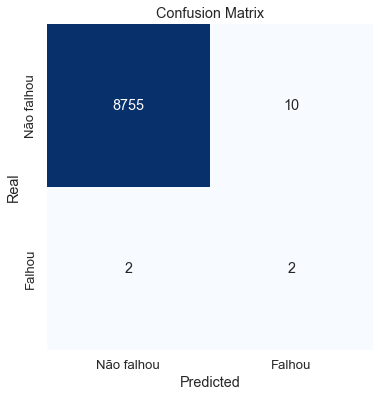

O valor da curva AUC:  0.7494295493439818
O valor da acurácia é:  0.9986315429353404
O valor de precision é:  0.16666666666666666
O valor de recall é : 0.5
O valor do f1-score é:  0.25


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8765.0
Falhou,0.17,0.50,0.25,4.0
macro avg,0.58,0.75,0.62,8769.0
weighted avg,1.00,1.00,1.00,8769.0


In [77]:
X_new = df[df["machineID"]==29].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==29].iloc[:,[27]].values

y_pred_mod = regression_model3.predict(X_new)

# Calcule o coeficiente de determinação (R²)
#r2 = r2_score(y_new, y_pred_mod)
accuracy = accuracy_score(y_new, y_pred_mod)
precision = precision_score(y_new, y_pred_mod)
recall = recall_score(y_new, y_pred_mod)
auc = roc_auc_score(y_new, y_pred_mod)
confusion = confusion_matrix(y_new, y_pred_mod)
f1score = f1_score(y_new, y_pred_mod)

class_rep2 = classification_report_df(y_new, y_pred_mod, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()



# Random Forest

C:\Users\Matheus Keitaro\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



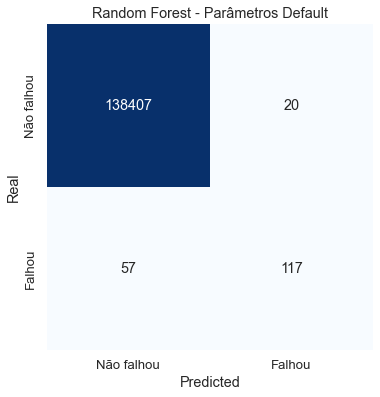

O valor da curva AUC:  0.8361346563095748
O valor da acurácia é:  0.9994444484527528
O valor de precision é:  0.8540145985401459
O valor de recall é : 0.6724137931034483
O valor do f1-score é:  0.7524115755627011


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,138427.0
Falhou,0.85,0.67,0.75,174.0
macro avg,0.93,0.84,0.88,138601.0
weighted avg,1.00,1.00,1.00,138601.0


In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split


X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um objeto de classificador Random Forest
rf_classifier1 = RandomForestClassifier(n_estimators = 500)

# Treine o classificador Random Forest
rf_classifier1.fit(X_train, y_train)

# Faça previsões nos dados de teste
y_pred = rf_classifier1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

class_rep2 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Random Forest - Parâmetros Default')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


X = df[df["machineID"].isin(lista)].iloc[:, [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 26, 29, 30]].values
y = df[df["machineID"].isin(lista)].iloc[:, [27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um objeto de classificador Random Forest
rf_classifier = RandomForestClassifier()

# Defina os parâmetros para o grid search

param_grid = {'min_samples_leaf':[5,7,10],
              'max_features':[0.5,'sqrt','log2'],
          'max_depth':[10,15,20],
          'criterion':['entropy','gini']}


# Crie o objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

# Execute a busca pelos melhores parâmetros
grid_search.fit(X_train, y_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros:", best_params)

# Faça previsões com o modelo usando os melhores parâmetros
y_pred = grid_search.predict(X_test)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)


print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score", f1score)
print("Matriz de Confusão:")
print(confusion)

"""Melhores parâmetros: {'criterion': 'gini', 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 7}
Coeficiente AUC: 0.8608636716841694
Acurácia: 0.9994949494949495
Precisão: 0.8413793103448276
Revocação: 0.7218934911242604
f1score 0.7770700636942675
Matriz de Confusão:
[[138408     23]
 [    47    122]]"""

C:\Users\Matheus Keitaro\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



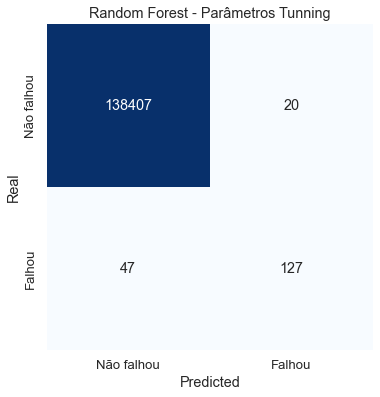

O valor da curva AUC:  0.8648702884934829
O valor da acurácia é:  0.9995165980043434
O valor de precision é:  0.8639455782312925
O valor de recall é : 0.7298850574712644
O valor do f1-score é:  0.7912772585669782
CPU times: total: 3min 51s
Wall time: 4min 12s


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,138427.0
Falhou,0.86,0.73,0.79,174.0
macro avg,0.93,0.86,0.90,138601.0
weighted avg,1.00,1.00,1.00,138601.0


In [79]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split


X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Melhores parâmetros: {'criterion': 'gini', 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 7}
# Crie um objeto de classificador Random Forest
rf_classifier2 = RandomForestClassifier(criterion = "entropy",
                                        max_depth = 15,
                                        max_features = 0.5,
                                        min_samples_leaf = 5,
                                         min_samples_split = 20)

# Treine o classificador Random Forest
rf_classifier2.fit(X_train, y_train)

# Faça previsões nos dados de teste
y_pred = rf_classifier2.predict(X_test)

# Avalie o desempenho do modelo

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)


class_rep2 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Random Forest - Parâmetros Tunning')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)


class_rep2.head()


C:\Users\Matheus Keitaro\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



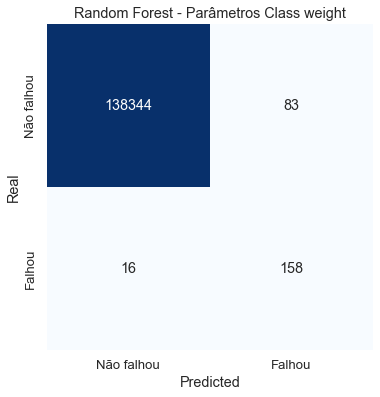

O valor da curva AUC:  0.9537231915008276
O valor da acurácia é:  0.9992857194392537
O valor de precision é:  0.6556016597510373
O valor de recall é : 0.9080459770114943
O valor do f1-score é:  0.7614457831325301
CPU times: total: 4min 8s
Wall time: 4min 17s


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,138427.0
Falhou,0.66,0.91,0.76,174.0
macro avg,0.83,0.95,0.88,138601.0
weighted avg,1.00,1.00,1.00,138601.0


In [80]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split


X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Melhores parâmetros: {'criterion': 'gini', 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 7}
# Crie um objeto de classificador Random Forest
rf_classifier3 = RandomForestClassifier(criterion = "entropy",
                                        max_depth = 15,
                                        max_features = 0.5,
                                        min_samples_leaf = 5,
                                         min_samples_split = 10,
                                       class_weight = "balanced_subsample")

# Treine o classificador Random Forest
rf_classifier3.fit(X_train, y_train)

# Faça previsões nos dados de teste
y_pred = rf_classifier3.predict(X_test)

# Avalie o desempenho do modelo

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)


class_rep2 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Random Forest - Parâmetros Class weight')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)


class_rep2.head()


# Validação Random forest

# Model 1

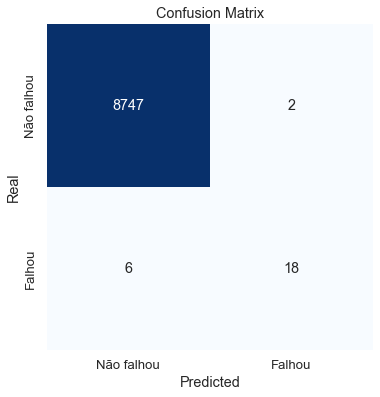

O valor da curva AUC:  0.8748857012229969
O valor da acurácia é:  0.9990881112504274
O valor de precision é:  0.9
O valor de recall é : 0.75
O valor do f1-score é:  0.8181818181818182


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8749.0
Falhou,0.90,0.75,0.82,24.0
macro avg,0.95,0.87,0.91,8773.0
weighted avg,1.00,1.00,1.00,8773.0


In [81]:
X_new = df[df["machineID"]==99].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==99].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred_rf = rf_classifier1.predict(X_new)

accuracy = accuracy_score(y_new, y_pred_rf)
precision = precision_score(y_new, y_pred_rf)
recall = recall_score(y_new, y_pred_rf)
confusion = confusion_matrix(y_new, y_pred_rf)
auc = roc_auc_score(y_new, y_pred_rf)
f1score = f1_score(y_new, y_pred_rf)


class_rep2 = classification_report_df(y_new, y_pred_rf, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)


class_rep2.head()


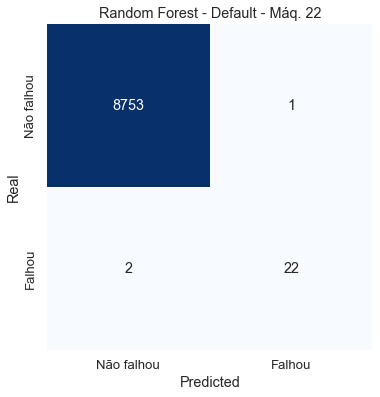

O valor da curva AUC:  0.9582762165867031
O valor da acurácia é:  0.9996582365003418
O valor de precision é:  0.9565217391304348
O valor de recall é : 0.9166666666666666
O valor do f1-score é:  0.9361702127659574


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8754.0
Falhou,0.96,0.92,0.94,24.0
macro avg,0.98,0.96,0.97,8778.0
weighted avg,1.00,1.00,1.00,8778.0


In [82]:
X_new = df[df["machineID"]==22].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==22].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred_rf = rf_classifier1.predict(X_new)

accuracy = accuracy_score(y_new, y_pred_rf)
precision = precision_score(y_new, y_pred_rf)
recall = recall_score(y_new, y_pred_rf)
confusion = confusion_matrix(y_new, y_pred_rf)
auc = roc_auc_score(y_new, y_pred_rf)
f1score = f1_score(y_new, y_pred_rf)


class_rep2 = classification_report_df(y_new, y_pred_rf, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Random Forest - Default - Máq. 22')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()



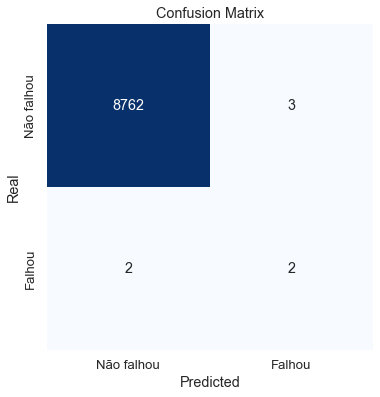

O valor da curva AUC:  0.7498288648031946
O valor da acurácia é:  0.9994298095563918
O valor de precision é:  0.4
O valor de recall é : 0.5
O valor do f1-score é:  0.4444444444444445


,precision,recall,f1-score,support
Não falhou,1.0,1.00,1.00,8765.0
Falhou,0.4,0.50,0.44,4.0
macro avg,0.7,0.75,0.72,8769.0
weighted avg,1.0,1.00,1.00,8769.0


In [83]:
X_new = df[df["machineID"]==29].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==29].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred_rf = rf_classifier1.predict(X_new)

accuracy = accuracy_score(y_new, y_pred_rf)
precision = precision_score(y_new, y_pred_rf)
recall = recall_score(y_new, y_pred_rf)
confusion = confusion_matrix(y_new, y_pred_rf)
auc = roc_auc_score(y_new, y_pred_rf)
f1score = f1_score(y_new, y_pred_rf)


class_rep2 = classification_report_df(y_new, y_pred_rf, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()


# model 2

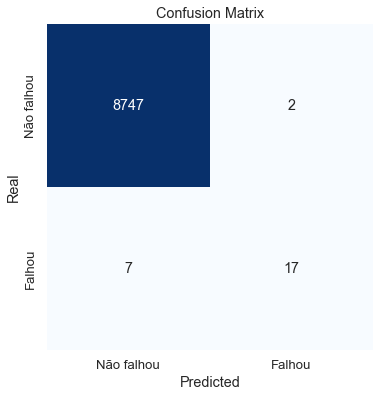

O valor da curva AUC:  0.8540523678896637
O valor da acurácia é:  0.9989741251567309
O valor de precision é:  0.8947368421052632
O valor de recall é : 0.7083333333333334
O valor do f1-score é:  0.7906976744186046


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8749.0
Falhou,0.89,0.71,0.79,24.0
macro avg,0.95,0.85,0.90,8773.0
weighted avg,1.00,1.00,1.00,8773.0


In [84]:
X_new = df[df["machineID"]==99].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==99].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred_rf = rf_classifier2.predict(X_new)

accuracy = accuracy_score(y_new, y_pred_rf)
precision = precision_score(y_new, y_pred_rf)
recall = recall_score(y_new, y_pred_rf)
confusion = confusion_matrix(y_new, y_pred_rf)
auc = roc_auc_score(y_new, y_pred_rf)
f1score = f1_score(y_new, y_pred_rf)



class_rep2 = classification_report_df(y_new, y_pred_rf, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()


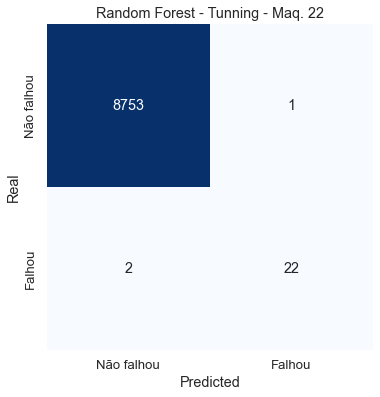

O valor da curva AUC:  0.9582762165867031
O valor da acurácia é:  0.9996582365003418
O valor de precision é:  0.9565217391304348
O valor de recall é : 0.9166666666666666
O valor do f1-score é:  0.9361702127659574


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8754.0
Falhou,0.96,0.92,0.94,24.0
macro avg,0.98,0.96,0.97,8778.0
weighted avg,1.00,1.00,1.00,8778.0


In [85]:
X_new = df[df["machineID"]==22].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==22].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred_rf = rf_classifier2.predict(X_new)

accuracy = accuracy_score(y_new, y_pred_rf)
precision = precision_score(y_new, y_pred_rf)
recall = recall_score(y_new, y_pred_rf)
confusion = confusion_matrix(y_new, y_pred_rf)
auc = roc_auc_score(y_new, y_pred_rf)
f1score = f1_score(y_new, y_pred_rf)



class_rep2 = classification_report_df(y_new, y_pred_rf, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Random Forest - Tunning - Maq. 22')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()


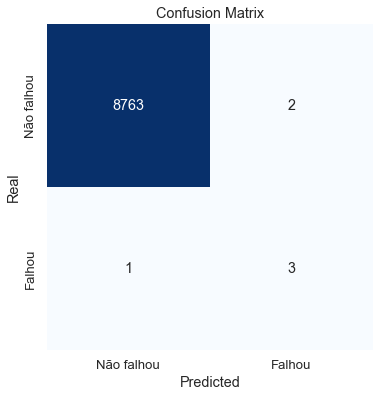

O valor da curva AUC:  0.8748859098687963
O valor da acurácia é:  0.9996578857338351
O valor de precision é:  0.6
O valor de recall é : 0.75
O valor do f1-score é:  0.6666666666666665


,precision,recall,f1-score,support
Não falhou,1.0,1.00,1.00,8765.0
Falhou,0.6,0.75,0.67,4.0
macro avg,0.8,0.87,0.83,8769.0
weighted avg,1.0,1.00,1.00,8769.0


In [86]:
X_new = df[df["machineID"]==29].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==29].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred_rf = rf_classifier2.predict(X_new)

accuracy = accuracy_score(y_new, y_pred_rf)
precision = precision_score(y_new, y_pred_rf)
recall = recall_score(y_new, y_pred_rf)
confusion = confusion_matrix(y_new, y_pred_rf)
auc = roc_auc_score(y_new, y_pred_rf)
f1score = f1_score(y_new, y_pred_rf)

class_rep2 = classification_report_df(y_new, y_pred_rf, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()



# model 3

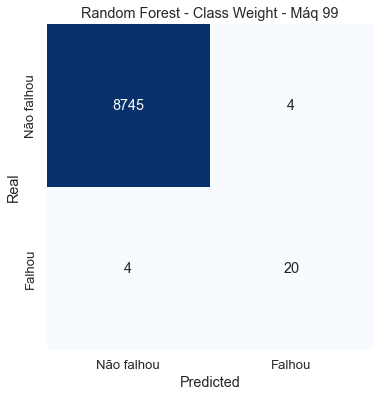

O valor da curva AUC:  0.9164380691126606
O valor da acurácia é:  0.9990881112504274
O valor de precision é:  0.8333333333333334
O valor de recall é : 0.8333333333333334
O valor do f1-score é:  0.8333333333333334


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8749.0
Falhou,0.83,0.83,0.83,24.0
macro avg,0.92,0.92,0.92,8773.0
weighted avg,1.00,1.00,1.00,8773.0


In [87]:
X_new = df[df["machineID"]==99].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==99].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred_rf = rf_classifier3.predict(X_new)

accuracy = accuracy_score(y_new, y_pred_rf)
precision = precision_score(y_new, y_pred_rf)
recall = recall_score(y_new, y_pred_rf)
confusion = confusion_matrix(y_new, y_pred_rf)
auc = roc_auc_score(y_new, y_pred_rf)
f1score = f1_score(y_new, y_pred_rf)



class_rep2 = classification_report_df(y_new, y_pred_rf, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Random Forest - Class Weight - Máq 99')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)


class_rep2.head()

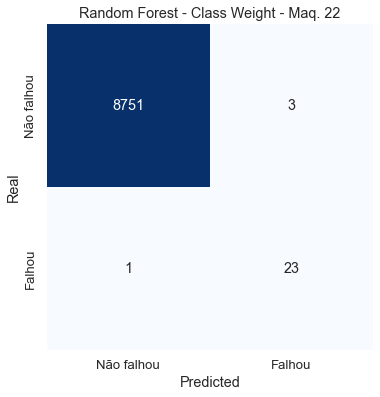

O valor da curva AUC:  0.9789953164267764
O valor da acurácia é:  0.9995443153337891
O valor de precision é:  0.8846153846153846
O valor de recall é : 0.9583333333333334
O valor do f1-score é:  0.9199999999999999


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8754.0
Falhou,0.88,0.96,0.92,24.0
macro avg,0.94,0.98,0.96,8778.0
weighted avg,1.00,1.00,1.00,8778.0


In [88]:
X_new = df[df["machineID"]==22].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==22].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred_rf = rf_classifier3.predict(X_new)

accuracy = accuracy_score(y_new, y_pred_rf)
precision = precision_score(y_new, y_pred_rf)
recall = recall_score(y_new, y_pred_rf)
confusion = confusion_matrix(y_new, y_pred_rf)
auc = roc_auc_score(y_new, y_pred_rf)
f1score = f1_score(y_new, y_pred_rf)


class_rep2 = classification_report_df(y_new, y_pred_rf, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Random Forest - Class Weight - Maq. 22')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)


class_rep2.head()


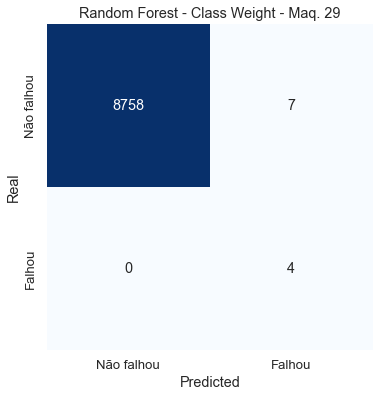

O valor da curva AUC:  0.9996006845407872
O valor da acurácia é:  0.9992017333789486
O valor de precision é:  0.36363636363636365
O valor de recall é : 1.0
O valor do f1-score é:  0.5333333333333333


,precision,recall,f1-score,support
Não falhou,1.00,1.0,1.00,8765.0
Falhou,0.36,1.0,0.53,4.0
macro avg,0.68,1.0,0.77,8769.0
weighted avg,1.00,1.0,1.00,8769.0


In [89]:
X_new = df[df["machineID"]==29].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==29].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred_rf = rf_classifier3.predict(X_new)

accuracy = accuracy_score(y_new, y_pred_rf)
precision = precision_score(y_new, y_pred_rf)
recall = recall_score(y_new, y_pred_rf)
confusion = confusion_matrix(y_new, y_pred_rf)
auc = roc_auc_score(y_new, y_pred_rf)
f1score = f1_score(y_new, y_pred_rf)


class_rep2 = classification_report_df(y_new, y_pred_rf, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Random Forest - Class Weight - Maq. 29')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()

# XGBOOSTING

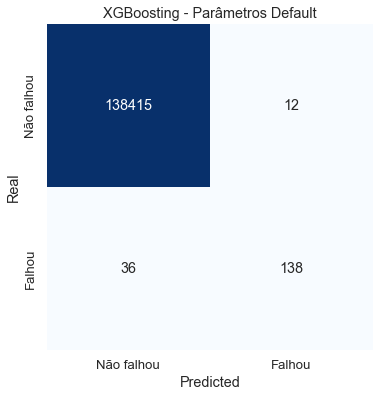

O valor da curva AUC:  0.8965083799926414
O valor da acurácia é:  0.9996536821523654
O valor de precision é:  0.92
O valor de recall é : 0.7931034482758621
O valor do f1-score é:  0.851851851851852
CPU times: total: 5min 57s
Wall time: 34.6 s


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,138427.0
Falhou,0.92,0.79,0.85,174.0
macro avg,0.96,0.90,0.93,138601.0
weighted avg,1.00,1.00,1.00,138601.0


In [90]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

X = df[df["machineID"].isin(lista)].iloc[:, [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 26, 29, 30]].values
y = df[df["machineID"].isin(lista)].iloc[:, [27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um objeto de classificador XGBoost
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic')

xgb_classifier.fit(X_train, y_train)

# Crie o objeto GridSearchCV

# Faça previsões com o modelo usando os melhores parâmetros
y_pred = xgb_classifier.predict(X_test)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

# Obtenha a probabilidade das classes positivas para o cálculo do AUC
#y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
#auc = roc_auc_score(y_test, y_pred_proba)
#f1score = f1_score(y_test, y_pred)

class_rep2 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('XGBoosting - Parâmetros Default')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)

class_rep2.head()



In [ ]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

X = df[df["machineID"].isin(lista)].iloc[:, [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 26,29,30]].values
y = df[df["machineID"].isin(lista)].iloc[:, [27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defina os parâmetros para o grid search
param_grid = {
    'max_depth': [3, 6, 9,12],
    'learning_rate': [0.01, 0.1, 0.2,0.5],
    'min_child_weight' = [1,5,6,10],
    'n_estimators': [50, 100, 200],
    'eval_metric': ['logloss']
}

# Crie um objeto de classificador XGBoost
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic')

# Crie o objeto GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='balanced_accuracy', cv=5)

# Execute a busca pelos melhores parâmetros
grid_search.fit(X_train, y_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros:", best_params)

# Faça previsões com o modelo usando os melhores parâmetros
y_pred = grid_search.predict(X_test)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")
print(confusion)

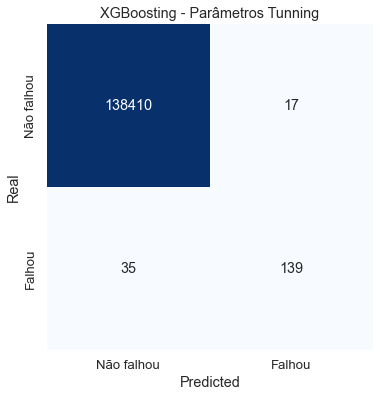

O valor da curva AUC:  0.8993638831504949
O valor da acurácia é:  0.9996248223317292
O valor de precision é:  0.8910256410256411
O valor de recall é : 0.7988505747126436
O valor do f1-score é:  0.8424242424242424
O valor do loglik é:  0.013522773834489816
CPU times: total: 4min 47s
Wall time: 36.2 s


,precision,recall,f1-score,support
Não falhou,1.00,1.0,1.00,138427.0
Falhou,0.89,0.8,0.84,174.0
macro avg,0.95,0.9,0.92,138601.0
weighted avg,1.00,1.0,1.00,138601.0


In [91]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score, log_loss

X = df[df["machineID"].isin(lista)].iloc[:, [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 26, 29, 30]].values
y = df[df["machineID"].isin(lista)].iloc[:, [27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defina os parâmetros para o grid search
param_grid = {'eval_metric': 'logloss', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}

# Crie um objeto de classificador XGBoost

xgb_classifier2 = xgb.XGBClassifier(eval_metric ='logloss',
                                    learning_rate= 0.2,
                                    max_depth= 6,
                                    min_child_weight = 6,
                                    n_estimators= 100,
                                    objective='binary:logistic')

xgb_classifier2.fit(X_train, y_train) 

# Crie o objeto GridSearchCV

# Faça previsões com o modelo usando os melhores parâmetros
y_pred = xgb_classifier2.predict(X_test)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)

# Obtenha a probabilidade das classes positivas para o cálculo do AUC
#y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
#auc = roc_auc_score(y_test, y_pred_proba)
#f1score = f1_score(y_test, y_pred)

class_rep2 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('XGBoosting - Parâmetros Tunning')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)
print("O valor do loglik é: ", logloss)

class_rep2.head()



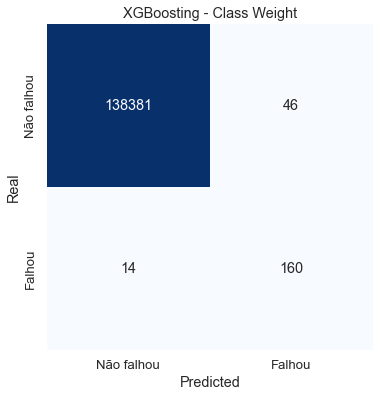

O valor da curva AUC:  0.9596039623855854
O valor da acurácia é:  0.9995671026904568
O valor de precision é:  0.7766990291262136
O valor de recall é : 0.9195402298850575
O valor do f1-score é:  0.8421052631578948
O valor do loglik é:  0.015603200578257441
CPU times: total: 48min 6s
Wall time: 5min 44s


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,138427.0
Falhou,0.78,0.92,0.84,174.0
macro avg,0.89,0.96,0.92,138601.0
weighted avg,1.00,1.00,1.00,138601.0


In [92]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

X = df[df["machineID"].isin(lista)].iloc[:, [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 26, 29, 30]].values
y = df[df["machineID"].isin(lista)].iloc[:, [27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defina os parâmetros para o grid search
param_grid = {'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}

# Crie um objeto de classificador XGBoost

class_weights = {0: 1, 1: 100}  # Class 0: 1, Class 1: 10

# Set "scale_pos_weight" based on class balance
pos_weight = int(sum((df[df["machineID"].isin(lista)].iloc[:, [27]].values) == False) / sum((df[df["machineID"].isin(lista)].iloc[:, [27]].values) == True))

xgb_classifier3 = xgb.XGBClassifier(scale_pos_weight=pos_weight,
                                    eval_metric ='logloss',
                                    min_child_weight = 6,
                                    learning_rate= 0.2,
                                    max_depth= 6,
                                    n_estimators= 1000,
                                    subsample = 0.6,
                                    objective='binary:logistic')

xgb_classifier3.fit(X_train, y_train)

# Crie o objeto GridSearchCV

# Faça previsões com o modelo usando os melhores parâmetros
y_pred = xgb_classifier3.predict(X_test)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

# Obtenha a probabilidade das classes positivas para o cálculo do AUC
#y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
#auc = roc_auc_score(y_test, y_pred_proba)
#f1score = f1_score(y_test, y_pred)

class_rep2 = classification_report_df(y_test, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('XGBoosting - Class Weight')
plt.show()

print("O valor da curva AUC: ",auc)
print("O valor da acurácia é: ", accuracy)
print("O valor de precision é: ",precision)
print("O valor de recall é :" ,recall)
print("O valor do f1-score é: ",f1score)
logloss = log_loss(y_test, y_pred)
print("O valor do loglik é: ", logloss)


class_rep2.head()



In [ ]:

class_weights = {0: 1, 1: 100}  # Class 0: 1, Class 1: 10

# Set "scale_pos_weight" based on class balance
pos_weight = int(sum((df[df["machineID"].isin(lista)].iloc[:, [27]].values) == False) / sum((df[df["machineID"].isin(lista)].iloc[:, [27]].values) == True))
pos_weight

# Validação XGboost

# model1

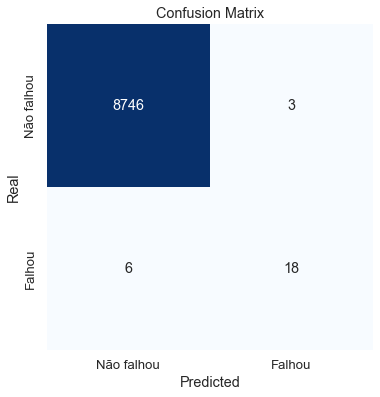

Coeficiente AUC: 0.8748285518344954
Acurácia: 0.9989741251567309
Precisão: 0.8571428571428571
Revocação: 0.75
f1score: 0.7999999999999999
Matriz de Confusão:


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.0,8749.0
Falhou,0.86,0.75,0.8,24.0
macro avg,0.93,0.87,0.9,8773.0
weighted avg,1.00,1.00,1.0,8773.0


In [93]:
X_new = df[df["machineID"]==99].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==99].iloc[:,[27]].values

y_pred = xgb_classifier.predict(X_new)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)
auc = roc_auc_score(y_new, y_pred)
f1score = f1_score(y_new, y_pred)

class_rep2 = classification_report_df(y_new, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")

class_rep2.head()


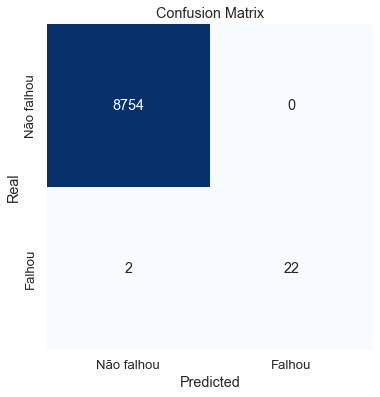

Coeficiente AUC: 0.9583333333333333
Acurácia: 0.9997721576668945
Precisão: 1.0
Revocação: 0.9166666666666666
f1score: 0.9565217391304348
Matriz de Confusão:


,precision,recall,f1-score,support
Não falhou,1.0,1.00,1.00,8754.0
Falhou,1.0,0.92,0.96,24.0
macro avg,1.0,0.96,0.98,8778.0
weighted avg,1.0,1.00,1.00,8778.0


In [94]:
X_new = df[df["machineID"]==22].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==22].iloc[:,[27]].values

y_pred = xgb_classifier.predict(X_new)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)
auc = roc_auc_score(y_new, y_pred)
f1score = f1_score(y_new, y_pred)

class_rep2 = classification_report_df(y_new, y_pred, target_names=["Não falhou", "Falhou"])
# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")

class_rep2.head()


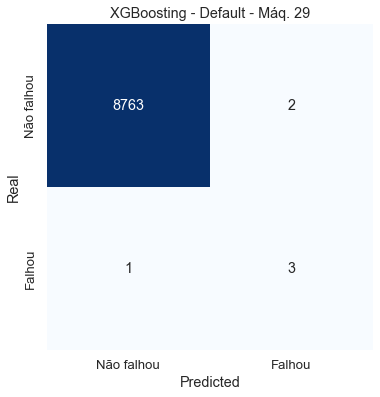

Coeficiente AUC: 0.8748859098687963
Acurácia: 0.9996578857338351
Precisão: 0.6
Revocação: 0.75
f1score: 0.6666666666666665
Matriz de Confusão:


,precision,recall,f1-score,support
Não falhou,1.0,1.00,1.00,8765.0
Falhou,0.6,0.75,0.67,4.0
macro avg,0.8,0.87,0.83,8769.0
weighted avg,1.0,1.00,1.00,8769.0


In [95]:
X_new = df[df["machineID"]==29].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==29].iloc[:,[27]].values

y_pred = xgb_classifier.predict(X_new)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)
auc = roc_auc_score(y_new, y_pred)
f1score = f1_score(y_new, y_pred)

class_rep2 = classification_report_df(y_new, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('XGBoosting - Default - Máq. 29')
plt.show()

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")

class_rep2.head()


# model 2

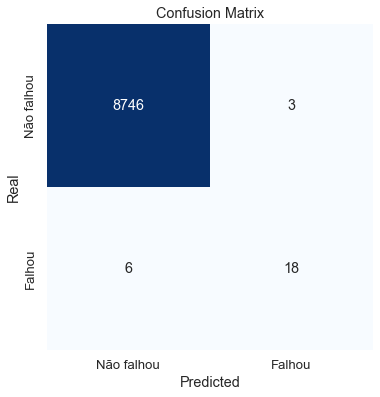

Coeficiente AUC: 0.8748285518344954
Acurácia: 0.9989741251567309
Precisão: 0.8571428571428571
Revocação: 0.75
f1score: 0.7999999999999999
Matriz de Confusão:


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.0,8749.0
Falhou,0.86,0.75,0.8,24.0
macro avg,0.93,0.87,0.9,8773.0
weighted avg,1.00,1.00,1.0,8773.0


In [96]:
X_new = df[df["machineID"]==99].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==99].iloc[:,[27]].values

y_pred = xgb_classifier2.predict(X_new)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)
auc = roc_auc_score(y_new, y_pred)
f1score = f1_score(y_new, y_pred)

class_rep2 = classification_report_df(y_new, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")

class_rep2.head()


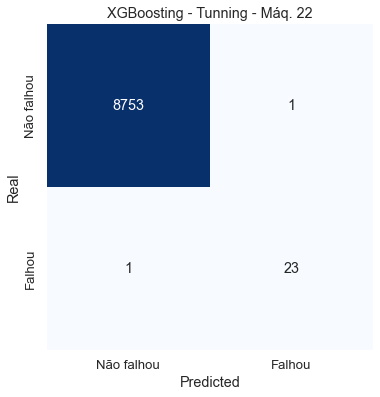

Coeficiente AUC: 0.9791095499200366
Acurácia: 0.9997721576668945
Precisão: 0.9583333333333334
Revocação: 0.9583333333333334
f1score: 0.9583333333333334
Matriz de Confusão:


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8754.0
Falhou,0.96,0.96,0.96,24.0
macro avg,0.98,0.98,0.98,8778.0
weighted avg,1.00,1.00,1.00,8778.0


In [97]:
X_new = df[df["machineID"]==22].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==22].iloc[:,[27]].values

y_pred = xgb_classifier2.predict(X_new)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)
auc = roc_auc_score(y_new, y_pred)
f1score = f1_score(y_new, y_pred)

class_rep2 = classification_report_df(y_new, y_pred, target_names=["Não falhou", "Falhou"])

# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('XGBoosting - Tunning - Máq. 22')
plt.show()

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")

class_rep2.head()


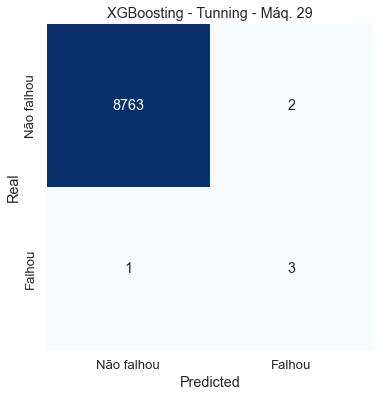

Coeficiente AUC: 0.8748859098687963
Acurácia: 0.9996578857338351
Precisão: 0.6
Revocação: 0.75
f1score: 0.6666666666666665
Matriz de Confusão:


,precision,recall,f1-score,support
Não falhou,1.0,1.00,1.00,8765.0
Falhou,0.6,0.75,0.67,4.0
macro avg,0.8,0.87,0.83,8769.0
weighted avg,1.0,1.00,1.00,8769.0


In [98]:
X_new = df[df["machineID"]==29].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==29].iloc[:,[27]].values


y_pred = xgb_classifier2.predict(X_new)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)
auc = roc_auc_score(y_new, y_pred)
f1score = f1_score(y_new, y_pred)

class_rep2 = classification_report_df(y_new, y_pred, target_names=["Não falhou", "Falhou"])


# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('XGBoosting - Tunning - Máq. 29')
plt.show()

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")


class_rep2.head()


# Model 3

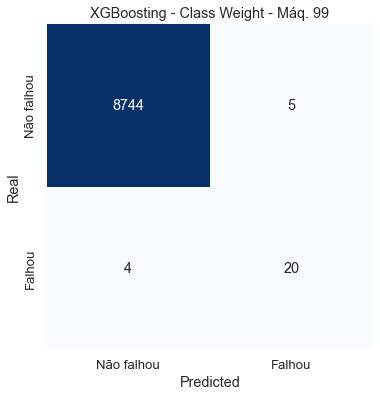

Coeficiente AUC: 0.916380919724159
Acurácia: 0.9989741251567309
Precisão: 0.8
Revocação: 0.8333333333333334
f1score: 0.816326530612245
Matriz de Confusão:


,precision,recall,f1-score,support
Não falhou,1.0,1.00,1.00,8749.0
Falhou,0.8,0.83,0.82,24.0
macro avg,0.9,0.92,0.91,8773.0
weighted avg,1.0,1.00,1.00,8773.0


In [99]:
X_new = df[df["machineID"]==99].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==99].iloc[:,[27]].values


y_pred = xgb_classifier3.predict(X_new)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)
auc = roc_auc_score(y_new, y_pred)
f1score = f1_score(y_new, y_pred)

class_rep2 = classification_report_df(y_new, y_pred, target_names=["Não falhou", "Falhou"])


# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('XGBoosting - Class Weight - Máq. 99')
plt.show()

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")


class_rep2.head()


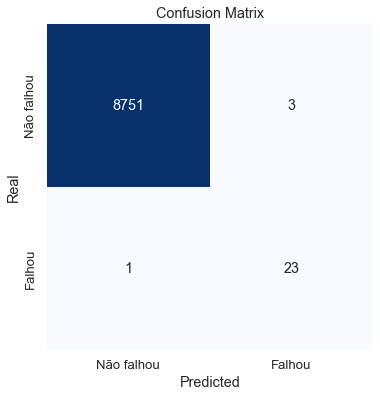

Coeficiente AUC: 0.9789953164267764
Acurácia: 0.9995443153337891
Precisão: 0.8846153846153846
Revocação: 0.9583333333333334
f1score: 0.9199999999999999
Matriz de Confusão:


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8754.0
Falhou,0.88,0.96,0.92,24.0
macro avg,0.94,0.98,0.96,8778.0
weighted avg,1.00,1.00,1.00,8778.0


In [100]:
X_new = df[df["machineID"]==22].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==22].iloc[:,[27]].values


y_pred = xgb_classifier3.predict(X_new)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)
auc = roc_auc_score(y_new, y_pred)
f1score = f1_score(y_new, y_pred)

class_rep2 = classification_report_df(y_new, y_pred, target_names=["Não falhou", "Falhou"])


# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")


class_rep2.head()


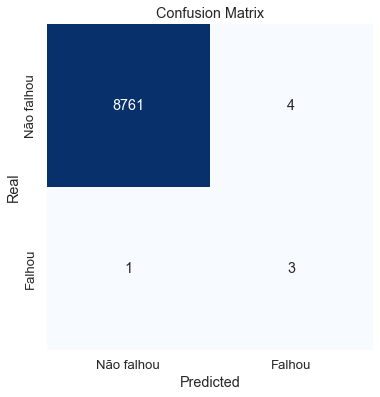

Coeficiente AUC: 0.8747718197375927
Acurácia: 0.9994298095563918
Precisão: 0.42857142857142855
Revocação: 0.75
f1score: 0.5454545454545454
Matriz de Confusão:


,precision,recall,f1-score,support
Não falhou,1.00,1.00,1.00,8765.0
Falhou,0.43,0.75,0.55,4.0
macro avg,0.71,0.87,0.77,8769.0
weighted avg,1.00,1.00,1.00,8769.0


In [101]:
X_new = df[df["machineID"]==29].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]].values
y_new = df[df["machineID"]==29].iloc[:,[27]].values


y_pred = xgb_classifier3.predict(X_new)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)
auc = roc_auc_score(y_new, y_pred)
f1score = f1_score(y_new, y_pred)

class_rep2 = classification_report_df(y_new, y_pred, target_names=["Não falhou", "Falhou"])


# Define os rótulos das classes

# Cria o heatmap usando a biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Define o tamanho da fonte
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=["Não falhou", "Falhou"], yticklabels=["Não falhou", "Falhou"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print("Coeficiente AUC:", auc)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("f1score:", f1score)
print("Matriz de Confusão:")


class_rep2.head()


# Curva de aprendizado XGboosting

In [ ]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import learning_curve

# Defina os parâmetros do modelo
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'logloss'
}

X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie o modelo XGBoost
model = xgb.XGBClassifier(**params)

# Calcule as curvas de aprendizado usando a função learning_curve
train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcule as médias e desvios padrão das pontuações de treinamento e validação
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plote as curvas de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Treinamento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, valid_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validação')
plt.fill_between(train_sizes, valid_mean + valid_std, valid_mean - valid_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Número de amostras de treinamento')
plt.ylabel('Pontuação')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Curva de aprendizado RandomForest

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import learning_curve

X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,29,30,31,32,33]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um objeto de classificador Random Forest
rf_classifier = RandomForestClassifier()

# Calcule as curvas de aprendizado usando a função learning_curve
train_sizes, train_scores, valid_scores = learning_curve(rf_classifier, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcule as médias e desvios padrão das pontuações de treinamento e validação
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plote as curvas de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Treinamento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, valid_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validação')
plt.fill_between(train_sizes, valid_mean + valid_std, valid_mean - valid_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Número de amostras de treinamento')
plt.ylabel('Pontuação')
plt.legend(loc='lower right')
plt.show()

In [ ]:
X_new = df[~df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30,31,32,33]].values
y_new = df[~df["machineID"].isin(lista)].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred = rf_classifier.predict(X_new)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("Matriz de Confusão:")
print(confusion)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = df[df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30,31,32,33]].values
y = df[df["machineID"].isin(lista)].iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um objeto de classificador Decision Tree
dt_classifier = DecisionTreeClassifier()

# Treine o classificador Decision Tree
dt_classifier.fit(X_train, y_train)

# Faça previsões nos dados de teste
y_pred = dt_classifier.predict(X_test)

# Avalie o desempenho do modelo
r2 = r2_score(y_test, y_pred)

print("Coeficiente de Determinação (R²):", r2)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("Matriz de Confusão:")
print(confusion)

In [ ]:
X_new = df[~df["machineID"].isin(lista)].iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30,31,32,33]].values
y_new = df[~df["machineID"].isin(lista)].iloc[:,[27]].values

# Faça previsões nos dados de teste
y_pred = dt_classifier.predict(X_new)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
confusion = confusion_matrix(y_new, y_pred)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("Matriz de Confusão:")
print(confusion)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtenha as probabilidades das classes positivas (no caso binário) do modelo
y_prob = dt_classifier.predict_proba(X_test)[:, 1]

# Calcule a taxa de falso positivo (FPR), a taxa de verdadeiro positivo (TPR) e os limiares usando as probabilidades
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcule a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plote a curva ROC
plt.figure(figsize = (25,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Defina as métricas de avaliação
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall'}

# Realize a validação cruzada com 5 folds
cv_results = cross_validate(xgb.XGBClassifier(**params), X, y, cv=5, scoring=scoring)

# Imprima a média e o desvio padrão dos resultados de acurácia, precisão e recall

print("Acurácia média:", cv_results['test_accuracy'].mean())
print("Precisão média:", cv_results['test_precision'].mean())
print("Revocação média:", cv_results['test_recall'].mean())

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Defina as métricas de avaliação
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall'}

# Realize a validação cruzada com 5 folds
cv_results = cross_validate(rf_classifier, X, y, cv=5, scoring=scoring)

# Imprima a média e o desvio padrão dos resultados de acurácia, precisão e recall
print("Acurácia média:", cv_results['test_accuracy'].mean())
print("Precisão média:", cv_results['test_precision'].mean())
print("Revocação média:", cv_results['test_recall'].mean())

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Defina as métricas de avaliação
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall'}

# Realize a validação cruzada com 5 folds
cv_results = cross_validate(dt_classifier, X, y, cv=5, scoring=scoring)

# Imprima a média e o desvio padrão dos resultados de acurácia, precisão e recall
print("Acurácia média:", cv_results['test_accuracy'].mean())
print("Precisão média:", cv_results['test_precision'].mean())
print("Revocação média:", cv_results['test_recall'].mean())

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

X = df.iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,29,30]].values
y = df.iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar um modelo sequencial
model = Sequential()

# Adicionar camadas densas ao modelo
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Fazer previsões nos dados de teste
y_pred = np.round(model.predict(X_test)).astype(int)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("Matriz de Confusão:")
print(confusion)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

X = df.iloc[:,[2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,29,30]].values
y = df.iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.astype(int)
# Criar um modelo sequencial
model = Sequential()

# Adicionar uma camada RNN
model.add(SimpleRNN(units=32, input_shape=(X_train.shape[1], 1)))

# Adicionar uma camada densa para classificação binária
model.add(Dense(units=1, activation='sigmoid'))

# Compilar o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Fazer previsões nos dados de teste
y_pred = np.round(model.predict(X_test)).astype(int)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("Matriz de Confusão:")
print(confusion)

In [ ]:
y_train

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

X = df.iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,29,30,31,32,33]].values
y = df.iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Criar um modelo sequencial
model = Sequential()

# Adicionar camadas convolucionais e de pooling
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adicionar mais camadas convolucionais e de pooling, se necessário

# Flattening
model.add(Flatten())

# Adicionar camadas densas para classificação binária
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compilar o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Fazer previsões nos dados de teste
y_pred = np.round(model.predict(X_test)).astype(int)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("Matriz de Confusão:")
print(confusion)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = df.iloc[:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,29,30,31,32,33]].values
y = df.iloc[:,[27]].values

# X representa as variáveis físicas e y representa o RUL (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um objeto de classificador SVM
svm_classifier = SVC()

# Treine o classificador SVM
svm_classifier.fit(X_train, y_train)

# Faça previsões nos dados de teste
y_pred = svm_classifier.predict(X_test)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("Matriz de Confusão:")
print(confusion)

In [ ]:
X_train

In [ ]:
df.corr(method = "pearson")

In [ ]:
# Defina a coluna de datas como o índice do DataFrame
df2 = df.copy()
#df2.set_index('datetime', inplace=True)

# Reamostrar para uma frequência de 6 horas e calcular a média
dados_6horas = df2.resample('6H').sum()

dados_diarios = dados_6horas.resample('D').sum()

# Verificar o novo DataFrame com os valores médios a cada 6 horas
print(dados_6horas)

In [ ]:
df2df["Erro_7d"] = soma
df["manutenção_2d"] = soma2

df["Erro_7d"] = soma
df["manutenção_2d"] = soma2
df["Erro_manut_2d"] = soma3
df["cont_erro"] = somae
df["cont_manut"] = somae2

In [ ]:
dfmerge_MF = df.groupby(["machineID", "Erro_7d"]).size().reset_index()
dfmerge_MF.columns = ["machineID", "Falha com erros 2dias", "Contagem"]
dfmerge_MF_pivot = pd.pivot(dfmerge_MF, index = "machineID", columns="Falha com erros 2dias", values = "Contagem" )

dfmerge_ME = df.groupby(["machineID", "manutenção_2d"]).size().reset_index()
dfmerge_ME.columns = ["machineID", "Falha com manutenção 1sem", "Contagem"]
dfmerge_ME_pivot = pd.pivot(dfmerge_ME, index = "machineID", columns="Falha com manutenção 1sem", values = "Contagem")


In [ ]:
dfmerge_MF_pivot

In [ ]:
ax = dfmerge_MF_pivot.plot(stacked = True, kind="bar", figsize = (25,10), fontsize = 14)
ax.set_xlabel("ID Máquinas", fontsize=20)
ax.set_ylabel("Falhas", fontsize=20)
ax.set_title("Falhas com ocorrência de erros nos ultimos 7 dias", fontsize = 25)

plt.show()

In [ ]:
ax = dfmerge_ME_pivot[True].plot(kind="bar", figsize = (25,10), fontsize = 14)
ax.set_xlabel("ID Máquinas", fontsize=25)
ax.set_ylabel("Falhas", fontsize=25)
ax.set_title("Falhas ocorridas apos manutenção realizada nos ultimos 7 dias", fontsize = 25)
plt.show()

In [ ]:
ax = dfmerge_MEF_pivot[True].plot(kind="bar", figsize = (25,10), fontsize = 14)
ax.set_xlabel("ID Máquinas", fontsize=25)
ax.set_ylabel("Falhas", fontsize=25)
ax.set_title("Falhas com ocorrência de erros e manutenção nos ultimos 7 dias", fontsize = 25)

plt.show()

In [ ]:
falhas_erro_tempo = df.groupby(["date","machineID", "Falha_c_erro2d"]).size().reset_index()
falhas_erro_tempo.columns = ["Data","machineID" ,"Falha_c_erro2d", "Contagem"]
falhas_erro_tempo_pivot = pd.pivot(falhas_erro_tempo, index = "Data", columns = ["machineID","Falha_c_erro2d"], values = "Contagem")
falhas_erro_tempo_pivot

In [ ]:
ax = falhas_erro_tempo_pivot[[(22,True),(29,True), (99,True)]].plot(figsize=(15, 6),  marker = "o", grid = True)
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Falhas ocasionadas com Erros nos ultimos 7 dias", fontsize=14)
plt.legend(fontsize=14)

plt.show()

In [ ]:
df["Idade_class"] = np.where(df["age"] <= 5, "Até 5 anos", np.where((df["age"] >5) & (df["age"] <=10), "Entre 6 e 10 anos", np.where((df["age"] > 10) & (df["age"] <=15), "Entre 11 e 15 anos", "Maior que 15 anos")))
df[["age","Idade_class"]] 

In [ ]:
df_age = df.groupby(["machineID", "age","Idade_class", "model"])[["Erro","Manutenção","Falha", "volt","rotate","pressure","vibration"]].sum().reset_index()
df_age.columns = ["ID da máquina", "Idade","Idade_class", "Modelo","Erro", "Manutenção", "Falha", "Voltagem bateria", "Rotação", "Pressão", "Vibração" ]
df_age

In [ ]:
s = dtale.show(df)
s.open_browser()

In [ ]:
df_age.describe()

In [ ]:
df_age["Erro_class"] = np.where(df_age["Erro"] <= 25, "Até 25 erros", np.where((df_age["Erro"] >25) & (df_age["Erro"] <= 35), "Entre 25 e 35 erros", np.where((df_age["Erro"] >35)&(df_age["Erro"] <=45), "Entre 35 e 45 erros", "Maior que 45 erros")))
df_age["Manutenção_class"] = np.where(df_age["Manutenção"] <= 25, "Até 25 manutenções", np.where((df_age["Manutenção"] >25) & (df_age["Manutenção"] <= 30), "Entre 25 e 30 manutenções", np.where((df_age["Manutenção"] >30)&(df_age["Erro"] <=35), "Entre 30 e 35 manutenções", "Maior que 35 manutenções")))
df_age["Falha_class"] = np.where(df_age["Falha"] <= 5, "Até 5 falhas", np.where((df_age["Falha"] >5) & (df_age["Falha"] <= 10), "Entre 5 e 10 falhas", np.where((df_age["Falha"] >10)&(df_age["Falha"] <=15), "Entre 10 e 15 falhas", "Maior que 15 falhas")))


In [ ]:
dfmerge.select_dtypes(include=["bool","object"]).groupby("date").sum().sum()

In [ ]:
df.dtypes

In [ ]:
df_agecor = df_age.corr(method = "pearson")
df_agecor

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_agecor, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Gráfico de Correlação')
plt.show()

In [ ]:
df.dtypes

In [ ]:
x = df_age["Idade"]
y = df_age["Erro"]

color_map = {
    "model1": "red",
    "model2": "green",
    "model3": "blue",
    "model4": "orange"
}

colors = df_age["Modelo"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 5))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Idade", fontsize = 14)
plt.ylabel("Erros", fontsize = 14)
plt.title("Relação de Idade das máquinas x Erros - Classificada por Modelo", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
x = df_age["Idade"]
y = df_age["Manutenção"]

color_map = {
    "model1": "red",
    "model2": "green",
    "model3": "blue",
    "model4": "orange"
}

colors = df_age["Modelo"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 5))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Idade", fontsize = 14)
plt.ylabel("Manutenções", fontsize = 14)
plt.title("Relação de Idade das máquinas x Manutenção - Classificada por Modelo", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
x = df_age["Idade"]
y = df_age["Falha"]

color_map = {
    "model1": "red",
    "model2": "green",
    "model3": "blue",
    "model4": "orange"
}

colors = df_age["Modelo"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 5))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Idade", fontsize = 14)
plt.ylabel("Falhas", fontsize = 14)
plt.title("Relação de Idade das máquinas x Falhas - Classificada por Modelo", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
color_map = {
    "Até 5 anos": "red",
    "Entre 6 e 10 anos": "green",
    "Entre 11 e 15 anos": "blue",
    "Maior que 15 anos": "orange"
}

x = df_age["Erro"]
y = df_age["Falha"]
colors = df_age["Idade_class"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Qti Erro", fontsize = 14)
plt.ylabel("Qti Falha", fontsize = 14)
plt.title("Relação de Erro x Falha - Classificada pela Idade da máquina", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
color_map = {
    "Até 5 anos": "red",
    "Entre 6 e 10 anos": "green",
    "Entre 11 e 15 anos": "blue",
    "Maior que 15 anos": "orange"
}

x = df_age["Voltagem bateria"]
y = df_age["Falha"]
colors = df_age["Idade_class"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Voltagem da Bateria", fontsize = 14)
plt.ylabel("Qti Falha", fontsize = 14)
plt.title("Relação da variavel Voltagem x Falha - Classificada pela idade da máquina", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
color_map = {
    "Até 25 erros": "green",
    "Entre 25 e 35 erros": "Blue",
    "Entre 35 e 45 erros": "orange",
    "Maior que 45 erros": "red"
}

x = df_age["Voltagem bateria"]
y = df_age["Falha"]
colors = df_age["Erro_class"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Voltagem da bateria", fontsize =14)
plt.ylabel("Qti Falha", fontsize = 14)
plt.title("Relação da variavel Voltagem Bateria x Falha - Classificada por Qti de erros", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
color_map = {
    "Até 5 anos": "red",
    "Entre 6 e 10 anos": "green",
    "Entre 11 e 15 anos": "blue",
    "Maior que 15 anos": "orange"
}

x = df_age["Rotação"]
y = df_age["Falha"]
colors = df_age["Idade_class"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Rotação", fontsize = 14)
plt.ylabel("Qti Falha", fontsize = 14)
plt.title("Relação da variavel Rotação x Falha - Classificada por Idade",fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements,fontsize =11)
plt.show()


In [ ]:
color_map = {
    "Até 25 erros": "green",
    "Entre 25 e 35 erros": "Blue",
    "Entre 35 e 45 erros": "orange",
    "Maior que 45 erros": "red"
}

x = df_age["Rotação"]
y = df_age["Falha"]
colors = df_age["Erro_class"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Rotação", fontsize =14)
plt.ylabel("Qti Falha", fontsize = 14)
plt.title("Relação da variavel Rotação x Falha - Classificada por Qti de erros", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
color_map = {
    "Até 5 anos": "red",
    "Entre 6 e 10 anos": "green",
    "Entre 11 e 15 anos": "blue",
    "Maior que 15 anos": "orange"
}

x = df_age["Pressão"]
y = df_age["Falha"]
colors = df_age["Idade_class"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Pressão", fontsize = 14)
plt.ylabel("Qti Falha", fontsize = 14)
plt.title("Relação da variavel Pressão x Falha - Classificada por Idade", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
color_map = {
    "Até 25 erros": "green",
    "Entre 25 e 35 erros": "Blue",
    "Entre 35 e 45 erros": "orange",
    "Maior que 45 erros": "red"
}

x = df_age["Pressão"]
y = df_age["Falha"]
colors = df_age["Erro_class"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Pressão", fontsize =14)
plt.ylabel("Qti Falha", fontsize = 14)
plt.title("Relação da variavel Pressão x Falha - Classificada por Qti de erros", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
color_map = {
    "Até 5 anos": "red",
    "Entre 6 e 10 anos": "green",
    "Entre 11 e 15 anos": "blue",
    "Maior que 15 anos": "orange"
}

x = df_age["Vibração"]
y = df_age["Falha"]
colors = df_age["Idade_class"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Vibração", fontsize = 14)
plt.ylabel("Qti Falha", fontsize = 14)
plt.title("Relação da variavel Vibração x Falha - Classificada por Idade da máquina", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
color_map = {
    "Até 25 erros": "green",
    "Entre 25 e 35 erros": "Blue",
    "Entre 35 e 45 erros": "orange",
    "Maior que 45 erros": "red"
}

x = df_age["Vibração"]
y = df_age["Falha"]
colors = df_age["Erro_class"].map(color_map)

# Calcular a regressão linear
coefficients = np.polyfit(x, y, 1)
m = coefficients[0]  # Coeficiente angular
b = coefficients[1]  # Coeficiente linear
regression_line = m * x + b

# Criar elementos da legenda correspondentes às categorias da coluna
legend_elements = []
for category, color in color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

# Plotar o gráfico de dispersão e a linha de regressão com a paleta de cores e a legenda
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, label="Dados")
plt.plot(x, regression_line, color="red", label="Regressão Linear")
plt.xlabel("Vibração", fontsize = 14)
plt.ylabel("Qti Falha", fontsize = 14)
plt.title("Relação da variavel Vibração x Falha - Classificada por Qti de Erros", fontsize = 14)
plt.grid(True)
plt.legend(handles=legend_elements, fontsize = 11)
plt.show()


In [ ]:
dfmerge_maq1 = dfmerge[dfmerge["machineID"] == 99]
dfmerge_maq2 = dfmerge[dfmerge["machineID"] == 29 ]
dfmerge_maq3 = dfmerge[dfmerge["machineID"] == 22 ]
dfmerge_maq4 = dfmerge[dfmerge["machineID"] == 98 ]
dfmerge_maq1["datetime"] = pd.to_datetime(dfmerge_maq1["datetime"], format="%Y-%m-%d %H:%M:%S")
dfmerge_maq2["datetime"] = pd.to_datetime(dfmerge_maq2["datetime"], format="%Y-%m-%d %H:%M:%S")
dfmerge_maq3["datetime"] = pd.to_datetime(dfmerge_maq3["datetime"], format="%Y-%m-%d %H:%M:%S")
dfmerge_maq4["datetime"] = pd.to_datetime(dfmerge_maq4["datetime"], format="%Y-%m-%d %H:%M:%S")
dfmerge_maq1.index = dfmerge_maq1["datetime"]
dfmerge_maq2.index = dfmerge_maq2["datetime"]
dfmerge_maq3.index = dfmerge_maq3["datetime"]
dfmerge_maq4.index = dfmerge_maq4["datetime"]

In [ ]:
dfmerge.groupby(["date", "Erro"]).size().reset_index()

In [ ]:
ax = erros_tempo_pivot[(22,True)].plot(figsize=(20, 7), marker="o", markersize=10, linestyle='None', grid=True, fontsize = 16)
ax2 = manutenção_tempo_pivot[(22,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax3 = falhas_tempo_pivot[(22,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax.set_xlabel("Data", fontsize=20)
ax.set_ylabel("Ocorrências", fontsize=20)
ax.set_title("Relação Erros/Manutenção/Falhas x Tempo - Máquina 22", fontsize=25)
plt.legend(fontsize=14)
plt.xticks(rotation = 45, fontsize=18)
plt.yticks([0,1,2,3,4,5], fontsize=18)

ax.legend(["Erros", "Manutenção", "Falhas"], fontsize=16)

In [ ]:
erros_tempo_pivot[22,True]

In [ ]:
import matplotlib.pyplot as plt

# Suponha que erros_tempo_pivot, manutenção_tempo_pivot e falhas_tempo_pivot sejam DataFrames com os dados correspondentes

plt.figure(figsize=(20, 7))  # Define o tamanho da figura

erros_tempo_pivot[(22,True)].plot(kind='line', style='o-', markersize=10, grid=True, fontsize=16)
manutenção_tempo_pivot[(22,True)].plot(kind='line', style='o-', markersize=10, grid=True, fontsize=16)
falhas_tempo_pivot[(22,True)].plot(kind='line', style='o-', markersize=10, grid=True, fontsize=16)

plt.xlabel("Data", fontsize=20)
plt.ylabel("Ocorrências", fontsize=20)
plt.title("Relação Erros/Manutenção/Falhas x Tempo - Máquina 22", fontsize=25)

plt.legend(["Erros", "Manutenção", "Falhas"], fontsize=16)

plt.show()  # Exibe o gráfico de linhas

In [ ]:
ax = erros_tempo_pivot[(29,True)].plot(figsize=(20, 7), marker="o", markersize=10, linestyle='None', grid=True, fontsize = 16)
ax2 = manutenção_tempo_pivot[(29,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax3 = falhas_tempo_pivot[(29,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax.set_xlabel("Data", fontsize=20)
ax.set_ylabel("Ocorrências", fontsize=20)
ax.set_title("Relação Erros/Manutenção/Falhas x Tempo - Máquina 29", fontsize=25)
plt.legend(fontsize=14)

ax.legend(["Erros", "Manutenção", "Falhas"], fontsize=16)

In [ ]:
ax = erros_tempo_pivot[(99,True)].plot(figsize=(20, 7), marker="o", markersize=10, linestyle='None', grid=True, fontsize = 16)
ax2 = manutenção_tempo_pivot[(99,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax3 = falhas_tempo_pivot[(99,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax.set_xlabel("Data", fontsize=20)
ax.set_ylabel("Ocorrências", fontsize=20)
ax.set_title("Relação Erros/Manutenção/Falhas x Tempo - Máquina 99", fontsize=25)
plt.legend(fontsize=14)

ax.legend(["Erros", "Manutenção", "Falhas"], fontsize=16)

In [ ]:
ax = erros_tempo_pivot[(98,True)].plot(figsize=(20, 7), marker="o", markersize=10, linestyle='None', grid=True, fontsize = 16)
ax2 = manutenção_tempo_pivot[(98,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax3 = falhas_tempo_pivot[(98,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax.set_xlabel("Data", fontsize=20)
ax.set_ylabel("Ocorrências", fontsize=20)
ax.set_title("Relação Erros/Manutenção/Falhas x Tempo - Máquina 98", fontsize=25)
plt.legend(fontsize=14)

ax.legend(["Erros", "Manutenção", "Falhas"], fontsize=16)

In [ ]:
fig, axs = plt.subplots(4,1, figsize = [20,15])
nome_objeto = "dfmerge_maq"
num = 1
fs = 16
plt.subplots_adjust(hspace=0.25)
#axs[0].plot(dfmerge_maq1["volt"])
axs[0].plot(dfmerge_maq1["volt"])
axs[0].set_title("Máquina 99", fontsize=fs)
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [25] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [50] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[0].set_ylabel("Voltagem", fontsize=16)
# Aumentar tamanho dos valores nos eixos
axs[0].tick_params(axis='both', which='major', labelsize=14)


axs[1].plot(eval(nome_objeto + str(num))["rotate"])
#axs[1].set_title("Rotação - máquina 99", fontsize=fs)
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [150] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [175] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [200] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[1].set_ylabel("Rotação", fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
#axs[1].legend(["Rotação", "Erros", "Manutenção", "Falhas"], fontsize=14)

axs[2].plot(eval(nome_objeto + str(num))["pressure"])
#axs[2].set_title("Pressão - máquina 99", fontsize=fs)
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [25] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [50] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[2].set_ylabel("Pressão", fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=14)
#axs[2].legend(["Pressão", "Erros", "Manutenção", "Falhas"], fontsize=14)

axs[3].plot(eval(nome_objeto + str(num))["vibration"])
#axs[3].set_title("Vibração - máquina 99", fontsize=fs)
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [-15] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [-10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [0] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[3].set_xlabel("Data", fontsize=16)
axs[3].set_ylabel("Vibração", fontsize=16)
axs[3].tick_params(axis='both', which='major', labelsize=14)
axs[3].legend(["Variavel", "Erros", "Manutenção", "Falhas"], fontsize=15, loc='lower right')




In [ ]:
fig, axs = plt.subplots(4,1, figsize = [20,15])
nome_objeto = "dfmerge_maq"
num = 2
fs = 16
plt.subplots_adjust(hspace=0.25)
#axs[0].plot(dfmerge_maq1["volt"])
axs[0].plot(dfmerge_maq1["volt"])
axs[0].set_title("Máquina 29", fontsize=fs)
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [25] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [50] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[0].set_ylabel("Voltagem", fontsize=16)
# Aumentar tamanho dos valores nos eixos
axs[0].tick_params(axis='both', which='major', labelsize=14)


axs[1].plot(eval(nome_objeto + str(num))["rotate"])
#axs[1].set_title("Rotação - máquina 99", fontsize=fs)
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [150] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [175] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [200] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[1].set_ylabel("Rotação", fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
#axs[1].legend(["Rotação", "Erros", "Manutenção", "Falhas"], fontsize=14)

axs[2].plot(eval(nome_objeto + str(num))["pressure"])
#axs[2].set_title("Pressão - máquina 99", fontsize=fs)
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [25] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [50] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[2].set_ylabel("Pressão", fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=14)
#axs[2].legend(["Pressão", "Erros", "Manutenção", "Falhas"], fontsize=14)

axs[3].plot(eval(nome_objeto + str(num))["vibration"])
#axs[3].set_title("Vibração - máquina 99", fontsize=fs)
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [-15] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [-10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [0] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[3].set_xlabel("Data", fontsize=16)
axs[3].set_ylabel("Vibração", fontsize=16)
axs[3].tick_params(axis='both', which='major', labelsize=14)
axs[3].legend(["Variavel", "Erros", "Manutenção", "Falhas"], fontsize=15, loc='lower right')




In [ ]:
fig, axs = plt.subplots(4,1, figsize = [20,15])
nome_objeto = "dfmerge_maq"
num = 3
fs = 16
plt.subplots_adjust(hspace=0.25)
#axs[0].plot(dfmerge_maq1["volt"])
axs[0].plot(dfmerge_maq1["volt"])
axs[0].set_title("Máquina 22", fontsize=fs)
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [25] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [50] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[0].set_ylabel("Voltagem", fontsize=16)
# Aumentar tamanho dos valores nos eixos
axs[0].tick_params(axis='both', which='major', labelsize=14)


axs[1].plot(eval(nome_objeto + str(num))["rotate"])
#axs[1].set_title("Rotação - máquina 99", fontsize=fs)
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [150] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [175] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [200] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[1].set_ylabel("Rotação", fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
#axs[1].legend(["Rotação", "Erros", "Manutenção", "Falhas"], fontsize=14)

axs[2].plot(eval(nome_objeto + str(num))["pressure"])
#axs[2].set_title("Pressão - máquina 99", fontsize=fs)
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [25] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [50] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[2].set_ylabel("Pressão", fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=14)
#axs[2].legend(["Pressão", "Erros", "Manutenção", "Falhas"], fontsize=14)

axs[3].plot(eval(nome_objeto + str(num))["vibration"])
#axs[3].set_title("Vibração - máquina 99", fontsize=fs)
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [-15] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [-10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [0] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[3].set_xlabel("Data", fontsize=16)
axs[3].set_ylabel("Vibração", fontsize=16)
axs[3].tick_params(axis='both', which='major', labelsize=14)
axs[3].legend(["Variavel", "Erros", "Manutenção", "Falhas"], fontsize=15, loc='lower right')




In [ ]:
fig, axs = plt.subplots(4,1, figsize = [20,15])
nome_objeto = "dfmerge_maq"
num = 4
fs = 16
plt.subplots_adjust(hspace=0.25)
#axs[0].plot(dfmerge_maq1["volt"])
axs[0].plot(dfmerge_maq1["volt"])
axs[0].set_title("Máquina 98", fontsize=fs)
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [25] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[0].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [50] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[0].set_ylabel("Voltagem", fontsize=16)
# Aumentar tamanho dos valores nos eixos
axs[0].tick_params(axis='both', which='major', labelsize=14)


axs[1].plot(eval(nome_objeto + str(num))["rotate"])
#axs[1].set_title("Rotação - máquina 99", fontsize=fs)
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [150] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [175] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[1].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [200] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[1].set_ylabel("Rotação", fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
#axs[1].legend(["Rotação", "Erros", "Manutenção", "Falhas"], fontsize=14)

axs[2].plot(eval(nome_objeto + str(num))["pressure"])
#axs[2].set_title("Pressão - máquina 99", fontsize=fs)
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [25] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[2].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [50] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[2].set_ylabel("Pressão", fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=14)
#axs[2].legend(["Pressão", "Erros", "Manutenção", "Falhas"], fontsize=14)

axs[3].plot(eval(nome_objeto + str(num))["vibration"])
#axs[3].set_title("Vibração - máquina 99", fontsize=fs)
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"], [-15] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Erro"], "datetime"].size, color="orange")
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"], [-10] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Manutenção"], "datetime"].size, color="green")
axs[3].scatter(eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"], [0] * eval(nome_objeto + str(num)).loc[eval(nome_objeto + str(num))["Falha"], "datetime"].size, color="red")
axs[3].set_xlabel("Data", fontsize=16)
axs[3].set_ylabel("Vibração", fontsize=16)
axs[3].tick_params(axis='both', which='major', labelsize=14)
axs[3].legend(["Variavel", "Erros", "Manutenção", "Falhas"], fontsize=15, loc='lower right')




In [ ]:
nome_objeto = "dfmerge_maq"
num = 1
eval(nome_objeto + str(num))

In [ ]:
dfmerge_maq1.head()

In [ ]:
    dfmerge_maq2.head()

In [ ]:
dfmerge_maq3.head()

In [ ]:
# Verificar se existem rótulos de índice duplicados
duplicated_labels = dfmerge_maq1.index.duplicated()
if duplicated_labels.any():
    # Lide com rótulos de índice duplicados (exemplo: remova duplicatas)
    dfmerge_maq1 = dfmerge_maq1[~duplicated_labels]

# Reindexar para frequência horária
dfmerge_maq1 = dfmerge_maq1.asfreq("D")

In [ ]:
dfmerge_maq1

In [ ]:
#Verificando valores duplicados no dataset completo (Mudar para data + machine iD)
print(f"Maquina 1 Nulos: {dfmerge_maq1.duplicated().any().sum()}, Maquina 2 Nulos: {dfmerge_maq2.duplicated().any().sum()}, Maquina 3 Nulos: {dfmerge_maq3.duplicated().any().sum()}")

In [ ]:
dfmerge_MF = dfmerge.groupby(["machineID", "Manutenção/Falha"]).size().reset_index()
dfmerge_MF.columns = ["machineID", "Manutenção/Falha", "Contagem"]
dfmerge_MF_pivot = pd.pivot(dfmerge_MF, index = "machineID", columns="Manutenção/Falha", )

dfmerge_ME = dfmerge.groupby(["machineID", "Manutenção/Erro"]).size().reset_index()
dfmerge_ME.columns = ["machineID", "Manutenção/Erro", "Contagem"]
dfmerge_ME_pivot = pd.pivot(dfmerge_ME, index = "machineID", columns="Manutenção/Erro", )

dfmerge_EF  = dfmerge.groupby(["machineID", "Erro/Falha"]).size().reset_index()
dfmerge_EF.columns = ["machineID", "Erro/Falha", "Contagem"]
dfmerge_EF_pivot = pd.pivot(dfmerge_EF, index = "machineID", columns="Erro/Falha", )

dfmerge_MEF = dfmerge.groupby(["machineID", "Manutenção/Erro/Falha"]).size().reset_index()
dfmerge_MEF.columns = ["machineID", "Manutenção/Erro/Falha", "Contagem"]
dfmerge_MEF_pivot = pd.pivot(dfmerge_MEF, index = "machineID", columns="Manutenção/Erro/Falha", )

In [ ]:
ax = dfmerge_MF_pivot["Contagem", True].plot(kind = "bar", figsize=(25, 10))
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Manutenção + Falha", fontsize=16)
plt.legend(fontsize=14)

plt.show()

In [ ]:
ax = dfmerge_ME_pivot["Contagem", True].plot(kind = "bar", figsize=(25, 10))
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Manutenção", fontsize=16)
plt.legend(fontsize=14)

plt.show()

In [ ]:
ax = dfmerge_EF_pivot["Contagem", True].plot(kind = "bar", figsize=(25, 10))
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Manutenção", fontsize=16)
plt.legend(fontsize=14)

plt.show()

In [ ]:
ax = dfmerge_MEF_pivot["Contagem", True].plot(kind = "bar", figsize=(25, 10))
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Manutenção", fontsize=16)
plt.legend(fontsize=14)

plt.show()

In [ ]:
dfmerge_MF_pivot["Contagem",True]

In [ ]:
df.dtypes

In [ ]:
fig, axs = plt.subplots(4,1, figsize = [20,15])
fs = 12 

axs[0].plot(dfmerge_maq1["volt"])
axs[0].set_title("Volt", fontsize=fs)
axs[1].plot(dfmerge_maq1["rotate"])
axs[1].set_title("Rotate", fontsize=fs)
axs[2].plot(dfmerge_maq1["pressure"])
axs[2].set_title("Pressure", fontsize=fs)
axs[3].plot(dfmerge_maq1["vibration"])
axs[3].set_title("Vibration", fontsize=fs)

In [ ]:
ax = erros_tempo_pivot[(22,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax2 = manutenção_tempo_pivot[(22,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax3 = falhas_tempo_pivot[(22,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Ocorrências", fontsize=16)
plt.legend(fontsize=14)

ax.legend(["Erros", "Manutenção", "Falhas"], fontsize=14)

In [ ]:
ax = erros_tempo_pivot[(22,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax2 = manutenção_tempo_pivot[(22,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax3 = falhas_tempo_pivot[(22,True)].plot(figsize=(25, 8), marker="o", markersize=10, linestyle='None', grid=True)
ax.set_xlabel("Data", fontsize=16)
ax.set_ylabel("Ocorrências", fontsize=16)
plt.legend(fontsize=14)

ax.legend(["Erros", "Manutenção", "Falhas"], fontsize=14)

In [ ]:
fig, axs = plt.subplots(4,1, figsize = [20,15])
fs = 12

axs[0].plot(dfmerge_maq2["volt"])
axs[0].set_title("Volt", fontsize=fs)
axs[1].plot(dfmerge_maq2["rotate"])
axs[1].set_title("Rotate", fontsize=fs)
axs[2].plot(dfmerge_maq2["pressure"])
axs[2].set_title("Pressure", fontsize=fs)
axs[3].plot(dfmerge_maq2["vibration"])
axs[3].set_title("Vibration", fontsize=fs)

In [ ]:
fig, axs = plt.subplots(4,1, figsize = [20,15])
fs = 12

axs[0].plot(dfmerge_maq3["volt"])
axs[0].set_title("Volt", fontsize=fs)
axs[1].plot(dfmerge_maq3["rotate"])
axs[1].set_title("Rotate", fontsize=fs)
axs[2].plot(dfmerge_maq3["pressure"])
axs[2].set_title("Pressure", fontsize=fs)
axs[3].plot(dfmerge_maq3["vibration"])
axs[3].set_title("Vibration", fontsize=fs)

In [ ]:
for i in dfmerge_maq1.iloc[:,2:6].columns:
    covariance = np.cov(dfmerge_maq1[i][:-1], dfmerge_maq1[i][1:])[0][1]
    print(f"A covariância da variavel {i} é: {covariance}")

In [ ]:
fig, axs = plt.subplots(4,1, figsize = [20,15])
fs = 12

axs[0].plot(telemetry["volt"][0:2180])
axs[0].set_title("Volt", fontsize=fs)
axs[1].plot(telemetry["rotate"][0:2180])
axs[1].set_title("Rotate", fontsize=fs)
axs[2].plot(telemetry["pressure"][0:2180])
axs[2].set_title("Pressure", fontsize=fs)
axs[3].plot(telemetry["vibration"][0:2180])
axs[3].set_title("Vibration", fontsize=fs)

In [ ]:
teste_arch(telemetry)

In [ ]:
telemetry["Year"] = telemetry.index.year
telemetry["Month"] = telemetry.index.month
telemetry["Day"] = telemetry.index.day

In [ ]:
#Correlação entre as variaveis
telemetry.iloc[:,0:6].corr(method='pearson')

In [ ]:
telemetry2 = telemetry.copy()

In [ ]:
telemetry2.asfreq("M")

In [1]:
lista = [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,29,30]
len(lista)

23